In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision as tv
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

import matplotlib.pyplot as plt
import random
import numpy as np
import math
import os

#MNIST dataset

In [67]:
def load_data(train_batch_size, test_batch_size):
    transform=transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))])
    train_set=tv.datasets.MNIST(
        root='./data',
        train=True,
        download=True,
        transform=transform
        )
    train_loader=torch.utils.data.DataLoader(
        train_set,
        batch_size=train_batch_size,
        shuffle=True,
        num_workers=2)
    test_set=tv.datasets.MNIST(
        root='./data',
        train=False,
        download=True,
        transform=transform
        )
    test_loader=torch.utils.data.DataLoader(
        test_set,
        batch_size=test_batch_size,
        shuffle=False,
        num_workers=2)
    print("data loaded successfully...")
    return train_loader,test_loader

In [68]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1=nn.Conv2d(1,6,5,stride=1,padding=2)
        self.conv2=nn.Conv2d(6,16,5,stride=1,padding=0)
        self.fc1=nn.Linear(16*5*5,120)
        self.fc2=nn.Linear(120,84)
        self.fc3=nn.Linear(84,10)
    def forward(self,x):
        x=F.max_pool2d(F.relu(self.conv1(x)),2)
        x=F.max_pool2d(F.relu(self.conv2(x)),2)
        x=x.view(-1,self.num_flat_features(x))
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=self.fc3(x)
        return x
    def num_flat_features(self,x):
        #x is a 4D tensor
        x_size=x.size()[1:]
        num=1
        for n in x_size:
            num*=n
        return num

In [69]:
def accuracy(model,x,neg=False):
    with torch.no_grad():
        correct=0
        total=0
        class_correct = list(0. for i in range(10))
        class_total = list(0. for i in range(10))
        for data in x:
            images,labels=data
            
            if neg:
            	images=-images
            
            images,labels=images, labels
            outputs=model(images)
            _,predicted=torch.max(outputs.data,1)
            total+=labels.size(0)
            correct+=(predicted==labels).sum().item()
            
        return (100 * correct / total)

In [70]:
def train(train_loader, test_loader, model, criterion, optimizer,epoch):
    model.train()
    running_loss=0
    for i,data in enumerate(train_loader,0):
        inputs,labels=data
        inputs,labels=inputs, labels
        optimizer.zero_grad()
        outputs=model(inputs)
        loss=criterion(outputs,labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss+=loss.item()
        if i%200==199:
            print("[epoch %d, iter %5d] loss: %.3f"%(epoch+1,i+1,running_loss/200))
            running_loss=0.0
    train_acc=accuracy(model,train_loader)
    test_acc=accuracy(model,test_loader)
    print("epoch %d: train_acc %.3f, test_acc %.3f"%(epoch+1,train_acc,test_acc))
    return train_acc,test_acc

In [71]:
def display(train_acc,test_acc):
    fig,ax=plt.subplots()
    ax.plot(range(1,len(train_acc)+1),train_acc,color='r',label='train_acc')
    ax.plot(range(1,len(test_acc)+1),test_acc,color='b',label='test_acc')
    ax.legend(loc='lower right')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Epoch vs Accuracy")
    plt.show()

In [72]:
def run_model(train_batch_size, lr, m):

  train_loader, test_loader = load_data(train_batch_size, 1000)

  # new model
  net=Net()

  # training
  learning_rate=lr
  momentum=m
  max_epoch=5
  criterion=nn.CrossEntropyLoss()
  optimizer=optim.SGD(net.parameters(),lr=learning_rate,momentum=momentum)

  train_acc=[]
  test_acc=[]
  for epoch in range(max_epoch):
      train_acc_t,test_acc_t=train(train_loader, test_loader, net, criterion, optimizer,epoch)
      train_acc.append(train_acc_t)
      test_acc.append(test_acc_t)

  #display(train_acc,test_acc)
  return train_acc, test_acc


In [12]:
train_acc_5runs = []
test_acc_5runs = []

for i in range(5):
  tr_acc, ts_acc = run_model(32, 0.001, 0.6)
  train_acc_5runs.append(tr_acc)
  test_acc_5runs.append(ts_acc)

data loaded successfully...
[epoch 1, iter   200] loss: 2.301
[epoch 1, iter   400] loss: 2.294
[epoch 1, iter   600] loss: 2.283
[epoch 1, iter   800] loss: 2.266
[epoch 1, iter  1000] loss: 2.235
[epoch 1, iter  1200] loss: 2.161
[epoch 1, iter  1400] loss: 1.927
[epoch 1, iter  1600] loss: 1.306
[epoch 1, iter  1800] loss: 0.801
epoch 1: train_acc 81.112, test_acc 81.670
[epoch 2, iter   200] loss: 0.558
[epoch 2, iter   400] loss: 0.487
[epoch 2, iter   600] loss: 0.427
[epoch 2, iter   800] loss: 0.385
[epoch 2, iter  1000] loss: 0.353
[epoch 2, iter  1200] loss: 0.347
[epoch 2, iter  1400] loss: 0.312
[epoch 2, iter  1600] loss: 0.296
[epoch 2, iter  1800] loss: 0.281
epoch 2: train_acc 92.352, test_acc 92.740
[epoch 3, iter   200] loss: 0.266
[epoch 3, iter   400] loss: 0.242
[epoch 3, iter   600] loss: 0.233
[epoch 3, iter   800] loss: 0.234
[epoch 3, iter  1000] loss: 0.236
[epoch 3, iter  1200] loss: 0.205
[epoch 3, iter  1400] loss: 0.203
[epoch 3, iter  1600] loss: 0.196
[e

In [13]:
train_acc_epoch_avg = np.array(train_acc_5runs).mean(axis=0)
test_acc_epoch_avg = np.array(test_acc_5runs).mean(axis=0)
train_acc_epoch_std = np.array(train_acc_5runs).mean(axis=0)
test_acc_epoch_std = np.array(test_acc_5runs).mean(axis=0)
train_acc_max = np.max(train_acc_epoch_avg)
test_acc_max = np.max(test_acc_epoch_avg)

train_acc1 = train_acc_5runs
test_acc1 = test_acc_5runs

print("Hyperparameters: train batch size = 32, learning rate = 0.001, momentum = 0.6")
print("Training statistics:")
print(f"Mean Train accuracy: {np.mean(train_acc_epoch_avg):.3f}")
print(f"STD Train accuracy: {np.std(train_acc_epoch_avg):.3f}")
print(f"Max Train accuracy: {train_acc_max:.3f}")
print("-"*150)
print("Testing statistics:")
print(f"Mean Test accuracy: {np.mean(test_acc_epoch_avg):.3f}")
print(f"STD Test accuracy: {np.std(test_acc_epoch_avg):.3f}")
print(f"Max Test accuracy: {test_acc_max:.3f}")

Hyperparameters: train batch size = 32, learning rate = 0.001, momentum = 0.6
Training statistics:
Mean Train accuracy: 92.653
STD Train accuracy: 4.172
Max Train accuracy: 96.411
------------------------------------------------------------------------------------------------------------------------------------------------------
Testing statistics:
Mean Test accuracy: 93.110
STD Test accuracy: 4.096
Max Test accuracy: 96.756


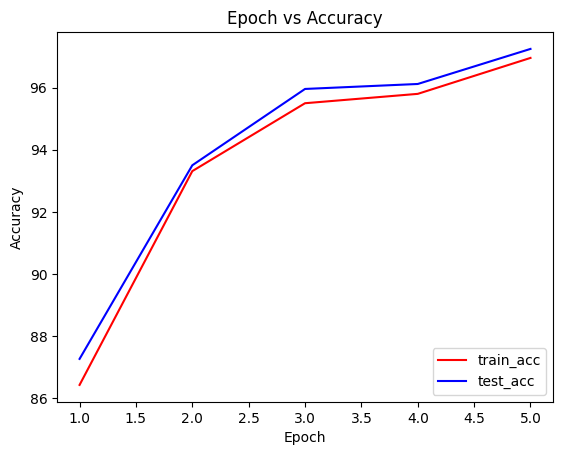

In [12]:
display(train_acc1[4], test_acc1[4])

In [14]:
train_acc_5runs = []
test_acc_5runs = []

for i in range(5):
  tr_acc, ts_acc = run_model(32, 0.01, 0.8)
  train_acc_5runs.append(tr_acc)
  test_acc_5runs.append(ts_acc)

data loaded successfully...
[epoch 1, iter   200] loss: 1.297
[epoch 1, iter   400] loss: 0.286
[epoch 1, iter   600] loss: 0.194
[epoch 1, iter   800] loss: 0.150
[epoch 1, iter  1000] loss: 0.129
[epoch 1, iter  1200] loss: 0.097
[epoch 1, iter  1400] loss: 0.111
[epoch 1, iter  1600] loss: 0.087
[epoch 1, iter  1800] loss: 0.091
epoch 1: train_acc 97.240, test_acc 97.320
[epoch 2, iter   200] loss: 0.058
[epoch 2, iter   400] loss: 0.072
[epoch 2, iter   600] loss: 0.077
[epoch 2, iter   800] loss: 0.063
[epoch 2, iter  1000] loss: 0.064
[epoch 2, iter  1200] loss: 0.065
[epoch 2, iter  1400] loss: 0.057
[epoch 2, iter  1600] loss: 0.059
[epoch 2, iter  1800] loss: 0.051
epoch 2: train_acc 98.738, test_acc 98.540
[epoch 3, iter   200] loss: 0.050
[epoch 3, iter   400] loss: 0.036
[epoch 3, iter   600] loss: 0.042
[epoch 3, iter   800] loss: 0.043
[epoch 3, iter  1000] loss: 0.040
[epoch 3, iter  1200] loss: 0.044
[epoch 3, iter  1400] loss: 0.040
[epoch 3, iter  1600] loss: 0.043
[e

In [15]:
train_acc_epoch_avg = np.array(train_acc_5runs).mean(axis=0)
test_acc_epoch_avg = np.array(test_acc_5runs).mean(axis=0)
train_acc_epoch_std = np.array(train_acc_5runs).mean(axis=0)
test_acc_epoch_std = np.array(test_acc_5runs).mean(axis=0)
train_acc_max = np.max(train_acc_epoch_avg)
test_acc_max = np.max(test_acc_epoch_avg)

train_acc2 = train_acc_5runs
test_acc2 = test_acc_5runs

print("Hyperparameters: train batch size = 32, learning rate = 0.01, momentum = 0.8")
print("Training statistics:")
print(f"Mean Train accuracy: {np.mean(train_acc_epoch_avg):.3f}")
print(f"STD Train accuracy: {np.std(train_acc_epoch_avg):.3f}")
print(f"Max Train accuracy: {train_acc_max:.3f}")
print("-"*150)
print("Testing statistics:")
print(f"Mean Test accuracy: {np.mean(test_acc_epoch_avg):.3f}")
print(f"STD Test accuracy: {np.std(test_acc_epoch_avg):.3f}")
print(f"Max Test accuracy: {test_acc_max:.3f}")

Hyperparameters: train batch size = 32, learning rate = 0.01, momentum = 0.8
Training statistics:
Mean Train accuracy: 98.696
STD Train accuracy: 0.601
Max Train accuracy: 99.214
------------------------------------------------------------------------------------------------------------------------------------------------------
Testing statistics:
Mean Test accuracy: 98.479
STD Test accuracy: 0.435
Max Test accuracy: 98.828


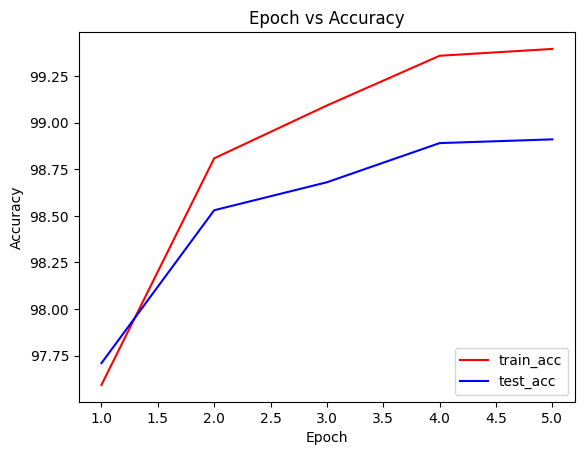

In [21]:
display(train_acc2[3], test_acc2[3])

In [16]:
train_acc_5runs = []
test_acc_5runs = []

for i in range(5):
  tr_acc, ts_acc = run_model(64, 0.01, 0.8)
  train_acc_5runs.append(tr_acc)
  test_acc_5runs.append(ts_acc)

data loaded successfully...
[epoch 1, iter   200] loss: 1.163
[epoch 1, iter   400] loss: 0.243
[epoch 1, iter   600] loss: 0.159
[epoch 1, iter   800] loss: 0.116
epoch 1: train_acc 97.328, test_acc 97.170
[epoch 2, iter   200] loss: 0.091
[epoch 2, iter   400] loss: 0.070
[epoch 2, iter   600] loss: 0.077
[epoch 2, iter   800] loss: 0.070
epoch 2: train_acc 98.498, test_acc 98.380
[epoch 3, iter   200] loss: 0.063
[epoch 3, iter   400] loss: 0.048
[epoch 3, iter   600] loss: 0.052
[epoch 3, iter   800] loss: 0.047
epoch 3: train_acc 98.490, test_acc 98.220
[epoch 4, iter   200] loss: 0.044
[epoch 4, iter   400] loss: 0.042
[epoch 4, iter   600] loss: 0.045
[epoch 4, iter   800] loss: 0.039
epoch 4: train_acc 98.825, test_acc 98.490
[epoch 5, iter   200] loss: 0.032
[epoch 5, iter   400] loss: 0.037
[epoch 5, iter   600] loss: 0.039
[epoch 5, iter   800] loss: 0.034
epoch 5: train_acc 99.073, test_acc 98.700
data loaded successfully...
[epoch 1, iter   200] loss: 1.154
[epoch 1, iter 

In [17]:
train_acc_epoch_avg = np.array(train_acc_5runs).mean(axis=0)
test_acc_epoch_avg = np.array(test_acc_5runs).mean(axis=0)
train_acc_epoch_std = np.array(train_acc_5runs).mean(axis=0)
test_acc_epoch_std = np.array(test_acc_5runs).mean(axis=0)
train_acc_max = np.max(train_acc_epoch_avg)
test_acc_max = np.max(test_acc_epoch_avg)

train_acc3 = train_acc_5runs
test_acc3 = test_acc_5runs

print("Hyperparameters: train batch size = 64, learning rate = 0.01, momentum = 0.8")
print("Training statistics:")
print(f"Mean Train accuracy: {np.mean(train_acc_epoch_avg):.3f}")
print(f"STD Train accuracy: {np.std(train_acc_epoch_avg):.3f}")
print(f"Max Train accuracy: {train_acc_max:.3f}")
print("-"*150)
print("Testing statistics:")
print(f"Mean Test accuracy: {np.mean(test_acc_epoch_avg):.3f}")
print(f"STD Test accuracy: {np.std(test_acc_epoch_avg):.3f}")
print(f"Max Test accuracy: {test_acc_max:.3f}")

Hyperparameters: train batch size = 64, learning rate = 0.01, momentum = 0.9
Training statistics:
Mean Train accuracy: 98.384
STD Train accuracy: 0.621
Max Train accuracy: 98.986
------------------------------------------------------------------------------------------------------------------------------------------------------
Testing statistics:
Mean Test accuracy: 98.228
STD Test accuracy: 0.480
Max Test accuracy: 98.648


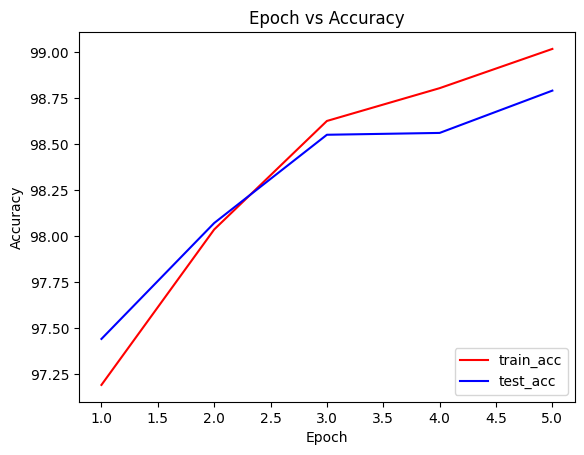

In [28]:
display(train_acc3[4], test_acc3[4])

#Fashion MNIST dataset

In [73]:
def load_data_fashion_mnist(train_batch_size, test_batch_size):
    transform=transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize((0.28604,), (0.35302,))])
    train_set=tv.datasets.FashionMNIST(
        root='./data',
        train=True,
        download=True,
        transform=transform
        )
    train_loader=torch.utils.data.DataLoader(
        train_set,
        batch_size=train_batch_size,
        shuffle=True,
        num_workers=2)
    test_set=tv.datasets.FashionMNIST(
        root='./data',
        train=False,
        download=True,
        transform=transform
        )
    test_loader=torch.utils.data.DataLoader(
        test_set,
        batch_size=test_batch_size,
        shuffle=False,
        num_workers=2)
    print("data loaded successfully...")
    return train_loader,test_loader

In [74]:
def run_model_fashion_mnist(train_batch_size, lr, m):

  train_loader, test_loader = load_data_fashion_mnist(train_batch_size, 1000)

  # new model
  net=Net()

  # training
  learning_rate=lr
  momentum=m
  max_epoch=5
  criterion=nn.CrossEntropyLoss()
  optimizer=optim.SGD(net.parameters(),lr=learning_rate,momentum=momentum)

  train_acc=[]
  test_acc=[]
  for epoch in range(max_epoch):
      train_acc_t,test_acc_t=train(train_loader, test_loader, net, criterion, optimizer,epoch)
      train_acc.append(train_acc_t)
      test_acc.append(test_acc_t)

  #display(train_acc,test_acc)
  return train_acc, test_acc


In [41]:
train_acc_5runs = []
test_acc_5runs = []

for i in range(5):
  tr_acc, ts_acc = run_model_fashion_mnist(32, 0.001, 0.6)
  train_acc_5runs.append(tr_acc)
  test_acc_5runs.append(ts_acc)

data loaded successfully...
[epoch 1, iter   200] loss: 2.298
[epoch 1, iter   400] loss: 2.282
[epoch 1, iter   600] loss: 2.259
[epoch 1, iter   800] loss: 2.203
[epoch 1, iter  1000] loss: 2.044
[epoch 1, iter  1200] loss: 1.556
[epoch 1, iter  1400] loss: 1.161
[epoch 1, iter  1600] loss: 1.001
[epoch 1, iter  1800] loss: 0.935
epoch 1: train_acc 66.518, test_acc 66.260
[epoch 2, iter   200] loss: 0.890
[epoch 2, iter   400] loss: 0.859
[epoch 2, iter   600] loss: 0.840
[epoch 2, iter   800] loss: 0.804
[epoch 2, iter  1000] loss: 0.786
[epoch 2, iter  1200] loss: 0.761
[epoch 2, iter  1400] loss: 0.757
[epoch 2, iter  1600] loss: 0.743
[epoch 2, iter  1800] loss: 0.743
epoch 2: train_acc 73.750, test_acc 73.390
[epoch 3, iter   200] loss: 0.730
[epoch 3, iter   400] loss: 0.712
[epoch 3, iter   600] loss: 0.695
[epoch 3, iter   800] loss: 0.699
[epoch 3, iter  1000] loss: 0.683
[epoch 3, iter  1200] loss: 0.676
[epoch 3, iter  1400] loss: 0.681
[epoch 3, iter  1600] loss: 0.646
[e

In [42]:
train_acc_epoch_avg = np.array(train_acc_5runs).mean(axis=0)
test_acc_epoch_avg = np.array(test_acc_5runs).mean(axis=0)
train_acc_epoch_std = np.array(train_acc_5runs).mean(axis=0)
test_acc_epoch_std = np.array(test_acc_5runs).mean(axis=0)
train_acc_max = np.max(train_acc_epoch_avg)
test_acc_max = np.max(test_acc_epoch_avg)

train_acc1 = train_acc_5runs
test_acc1 = test_acc_5runs

print("Hyperparameters: train batch size = 32, learning rate = 0.001, momentum = 0.6")
print("Training statistics:")
print(f"Mean Train accuracy: {np.mean(train_acc_epoch_avg):.3f}")
print(f"STD Train accuracy: {np.std(train_acc_epoch_avg):.3f}")
print(f"Max Train accuracy: {train_acc_max:.3f}")
print("-"*150)
print("Testing statistics:")
print(f"Mean Test accuracy: {np.mean(test_acc_epoch_avg):.3f}")
print(f"STD Test accuracy: {np.std(test_acc_epoch_avg):.3f}")
print(f"Max Test accuracy: {test_acc_max:.3f}")

Hyperparameters: train batch size = 32, learning rate = 0.001, momentum = 0.6
Training statistics:
Mean Train accuracy: 74.092
STD Train accuracy: 5.839
Max Train accuracy: 80.056
------------------------------------------------------------------------------------------------------------------------------------------------------
Testing statistics:
Mean Test accuracy: 73.256
STD Test accuracy: 5.666
Max Test accuracy: 78.952


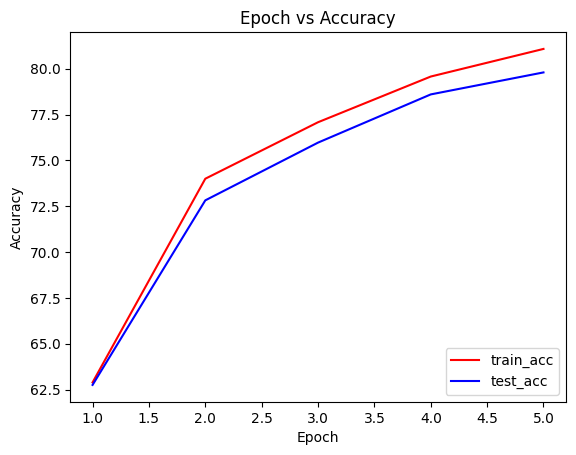

In [33]:
display(train_acc1[3], test_acc1[3])

In [43]:
train_acc_5runs = []
test_acc_5runs = []

for i in range(5):
  tr_acc, ts_acc = run_model_fashion_mnist(32, 0.01, 0.8)
  train_acc_5runs.append(tr_acc)
  test_acc_5runs.append(ts_acc)

data loaded successfully...
[epoch 1, iter   200] loss: 1.482
[epoch 1, iter   400] loss: 0.772
[epoch 1, iter   600] loss: 0.650
[epoch 1, iter   800] loss: 0.571
[epoch 1, iter  1000] loss: 0.539
[epoch 1, iter  1200] loss: 0.516
[epoch 1, iter  1400] loss: 0.472
[epoch 1, iter  1600] loss: 0.426
[epoch 1, iter  1800] loss: 0.408
epoch 1: train_acc 86.380, test_acc 84.990
[epoch 2, iter   200] loss: 0.405
[epoch 2, iter   400] loss: 0.402
[epoch 2, iter   600] loss: 0.351
[epoch 2, iter   800] loss: 0.349
[epoch 2, iter  1000] loss: 0.373
[epoch 2, iter  1200] loss: 0.348
[epoch 2, iter  1400] loss: 0.353
[epoch 2, iter  1600] loss: 0.342
[epoch 2, iter  1800] loss: 0.330
epoch 2: train_acc 88.450, test_acc 87.080
[epoch 3, iter   200] loss: 0.332
[epoch 3, iter   400] loss: 0.321
[epoch 3, iter   600] loss: 0.293
[epoch 3, iter   800] loss: 0.312
[epoch 3, iter  1000] loss: 0.311
[epoch 3, iter  1200] loss: 0.289
[epoch 3, iter  1400] loss: 0.307
[epoch 3, iter  1600] loss: 0.323
[e

In [44]:
train_acc_epoch_avg = np.array(train_acc_5runs).mean(axis=0)
test_acc_epoch_avg = np.array(test_acc_5runs).mean(axis=0)
train_acc_epoch_std = np.array(train_acc_5runs).mean(axis=0)
test_acc_epoch_std = np.array(test_acc_5runs).mean(axis=0)
train_acc_max = np.max(train_acc_epoch_avg)
test_acc_max = np.max(test_acc_epoch_avg)

train_acc2 = train_acc_5runs
test_acc2 = test_acc_5runs

print("Hyperparameters: train batch size = 32, learning rate = 0.01, momentum = 0.8")
print("Training statistics:")
print(f"Mean Train accuracy: {np.mean(train_acc_epoch_avg):.3f}")
print(f"STD Train accuracy: {np.std(train_acc_epoch_avg):.3f}")
print(f"Max Train accuracy: {train_acc_max:.3f}")
print("-"*150)
print("Testing statistics:")
print(f"Mean Test accuracy: {np.mean(test_acc_epoch_avg):.3f}")
print(f"STD Test accuracy: {np.std(test_acc_epoch_avg):.3f}")
print(f"Max Test accuracy: {test_acc_max:.3f}")

Hyperparameters: train batch size = 32, learning rate = 0.01, momentum = 0.8
Training statistics:
Mean Train accuracy: 89.035
STD Train accuracy: 1.976
Max Train accuracy: 91.339
------------------------------------------------------------------------------------------------------------------------------------------------------
Testing statistics:
Mean Test accuracy: 87.430
STD Test accuracy: 1.672
Max Test accuracy: 89.252


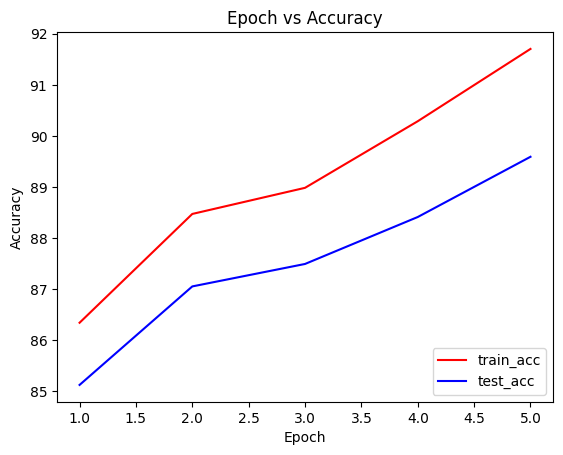

In [42]:
display(train_acc2[2], test_acc2[2])

In [45]:
train_acc_5runs = []
test_acc_5runs = []

for i in range(5):
  tr_acc, ts_acc = run_model_fashion_mnist(64, 0.01, 0.8)
  train_acc_5runs.append(tr_acc)
  test_acc_5runs.append(ts_acc)

data loaded successfully...
[epoch 1, iter   200] loss: 1.430
[epoch 1, iter   400] loss: 0.695
[epoch 1, iter   600] loss: 0.589
[epoch 1, iter   800] loss: 0.530
epoch 1: train_acc 82.153, test_acc 81.210
[epoch 2, iter   200] loss: 0.456
[epoch 2, iter   400] loss: 0.439
[epoch 2, iter   600] loss: 0.412
[epoch 2, iter   800] loss: 0.391
epoch 2: train_acc 86.882, test_acc 85.660
[epoch 3, iter   200] loss: 0.363
[epoch 3, iter   400] loss: 0.353
[epoch 3, iter   600] loss: 0.352
[epoch 3, iter   800] loss: 0.343
epoch 3: train_acc 87.652, test_acc 86.270
[epoch 4, iter   200] loss: 0.329
[epoch 4, iter   400] loss: 0.320
[epoch 4, iter   600] loss: 0.314
[epoch 4, iter   800] loss: 0.314
epoch 4: train_acc 88.537, test_acc 87.120
[epoch 5, iter   200] loss: 0.299
[epoch 5, iter   400] loss: 0.292
[epoch 5, iter   600] loss: 0.293
[epoch 5, iter   800] loss: 0.292
epoch 5: train_acc 90.052, test_acc 88.450
data loaded successfully...
[epoch 1, iter   200] loss: 1.435
[epoch 1, iter 

In [46]:
train_acc_epoch_avg = np.array(train_acc_5runs).mean(axis=0)
test_acc_epoch_avg = np.array(test_acc_5runs).mean(axis=0)
train_acc_epoch_std = np.array(train_acc_5runs).mean(axis=0)
test_acc_epoch_std = np.array(test_acc_5runs).mean(axis=0)
train_acc_max = np.max(train_acc_epoch_avg)
test_acc_max = np.max(test_acc_epoch_avg)

train_acc3 = train_acc_5runs
test_acc3 = test_acc_5runs

print("Hyperparameters: train batch size = 64, learning rate = 0.01, momentum = 0.8")
print("Training statistics:")
print(f"Mean Train accuracy: {np.mean(train_acc_epoch_avg):.3f}")
print(f"STD Train accuracy: {np.std(train_acc_epoch_avg):.3f}")
print(f"Max Train accuracy: {train_acc_max:.3f}")
print("-"*150)
print("Testing statistics:")
print(f"Mean Test accuracy: {np.mean(test_acc_epoch_avg):.3f}")
print(f"STD Test accuracy: {np.std(test_acc_epoch_avg):.3f}")
print(f"Max Test accuracy: {test_acc_max:.3f}")

Hyperparameters: train batch size = 64, learning rate = 0.01, momentum = 0.8
Training statistics:
Mean Train accuracy: 87.133
STD Train accuracy: 2.792
Max Train accuracy: 89.827
------------------------------------------------------------------------------------------------------------------------------------------------------
Testing statistics:
Mean Test accuracy: 85.874
STD Test accuracy: 2.554
Max Test accuracy: 88.256


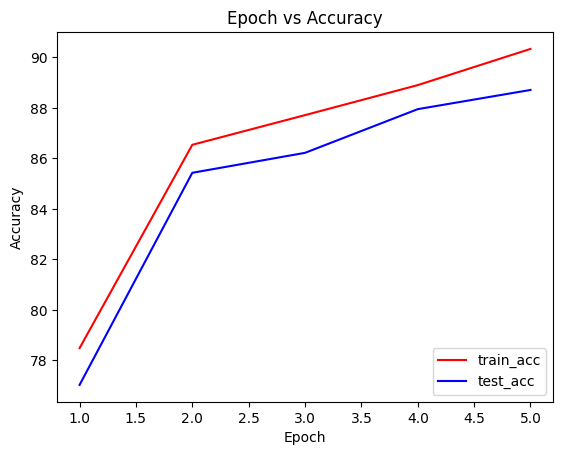

In [51]:
display(train_acc3[1], test_acc3[1])

# CIFAR 10 dataset 

In [75]:
def load_data_cifar10(train_batch_size, test_batch_size):
    transform=transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize((0.4914,0.4822,0.4465), (0.2470,0.2435,0.2616))])
    train_set=tv.datasets.CIFAR10(
        root='./data',
        train=True,
        download=True,
        transform=transform
        )
    train_loader=torch.utils.data.DataLoader(
        train_set,
        batch_size=train_batch_size,
        shuffle=True,
        num_workers=2)
    test_set=tv.datasets.CIFAR10(
        root='./data',
        train=False,
        download=True,
        transform=transform
        )
    test_loader=torch.utils.data.DataLoader(
        test_set,
        batch_size=test_batch_size,
        shuffle=False,
        num_workers=2)
    print("data loaded successfully...")
    return train_loader,test_loader

In [76]:
class Net_CIFAR10(nn.Module):
    def __init__(self):
        super(Net_CIFAR10,self).__init__()
        self.conv1=nn.Conv2d(3,6,5,stride=1,padding=0)
        self.conv2=nn.Conv2d(6,16,5,stride=1,padding=0)
        self.fc1=nn.Linear(16*5*5,120)
        self.fc2=nn.Linear(120,84)
        self.fc3=nn.Linear(84,10)
    def forward(self,x):
        x=F.max_pool2d(F.relu(self.conv1(x)),2)
        x=F.max_pool2d(F.relu(self.conv2(x)),2)
        x=x.view(-1,self.num_flat_features(x))
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=self.fc3(x)
        return x
    def num_flat_features(self,x):
        #x is a 4D tensor
        x_size=x.size()[1:]
        num=1
        for n in x_size:
            num*=n
        return num

In [77]:
def run_model_cifar10(train_batch_size, lr, m):

  train_loader, test_loader = load_data_cifar10(train_batch_size, 1000)

  # new model
  net=Net_CIFAR10()

  # training
  learning_rate=lr
  momentum=m
  max_epoch=10
  criterion=nn.CrossEntropyLoss()
  optimizer=optim.SGD(net.parameters(),lr=learning_rate,momentum=momentum)

  train_acc=[]
  test_acc=[]
  for epoch in range(max_epoch):
      train_acc_t,test_acc_t=train(train_loader, test_loader, net, criterion, optimizer,epoch)
      train_acc.append(train_acc_t)
      test_acc.append(test_acc_t)

  #display(train_acc,test_acc)
  return train_acc, test_acc


In [14]:
train_acc_5runs = []
test_acc_5runs = []

for i in range(5):
  tr_acc, ts_acc = run_model_cifar10(32, 0.001, 0.6)
  train_acc_5runs.append(tr_acc)
  test_acc_5runs.append(ts_acc)

Files already downloaded and verified
Files already downloaded and verified
data loaded successfully...
[epoch 1, iter   200] loss: 2.302
[epoch 1, iter   400] loss: 2.298
[epoch 1, iter   600] loss: 2.294
[epoch 1, iter   800] loss: 2.288
[epoch 1, iter  1000] loss: 2.280
[epoch 1, iter  1200] loss: 2.266
[epoch 1, iter  1400] loss: 2.245
epoch 1: train_acc 19.438, test_acc 19.290
[epoch 2, iter   200] loss: 2.160
[epoch 2, iter   400] loss: 2.095
[epoch 2, iter   600] loss: 2.050
[epoch 2, iter   800] loss: 2.008
[epoch 2, iter  1000] loss: 1.997
[epoch 2, iter  1200] loss: 1.967
[epoch 2, iter  1400] loss: 1.947
epoch 2: train_acc 30.402, test_acc 30.360
[epoch 3, iter   200] loss: 1.925
[epoch 3, iter   400] loss: 1.888
[epoch 3, iter   600] loss: 1.879
[epoch 3, iter   800] loss: 1.855
[epoch 3, iter  1000] loss: 1.843
[epoch 3, iter  1200] loss: 1.814
[epoch 3, iter  1400] loss: 1.805
epoch 3: train_acc 36.020, test_acc 36.090
[epoch 4, iter   200] loss: 1.746
[epoch 4, iter   40

In [15]:
train_acc_epoch_avg = np.array(train_acc_5runs).mean(axis=0)
test_acc_epoch_avg = np.array(test_acc_5runs).mean(axis=0)
train_acc_epoch_std = np.array(train_acc_5runs).mean(axis=0)
test_acc_epoch_std = np.array(test_acc_5runs).mean(axis=0)
train_acc_max = np.max(train_acc_epoch_avg)
test_acc_max = np.max(test_acc_epoch_avg)

train_acc1 = train_acc_5runs
test_acc1 = test_acc_5runs

print("Hyperparameters: train batch size = 32, learning rate = 0.001, momentum = 0.6")
print("Training statistics:")
print(f"Mean Train accuracy: {np.mean(train_acc_epoch_avg):.3f}")
print(f"STD Train accuracy: {np.std(train_acc_epoch_avg):.3f}")
print(f"Max Train accuracy: {train_acc_max:.3f}")
print("-"*150)
print("Testing statistics:")
print(f"Mean Test accuracy: {np.mean(test_acc_epoch_avg):.3f}")
print(f"STD Test accuracy: {np.std(test_acc_epoch_avg):.3f}")
print(f"Max Test accuracy: {test_acc_max:.3f}")

Hyperparameters: train batch size = 32, learning rate = 0.001, momentum = 0.6
Training statistics:
Mean Train accuracy: 30.287
STD Train accuracy: 9.328
Max Train accuracy: 40.885
------------------------------------------------------------------------------------------------------------------------------------------------------
Testing statistics:
Mean Test accuracy: 30.482
STD Test accuracy: 9.485
Max Test accuracy: 41.142


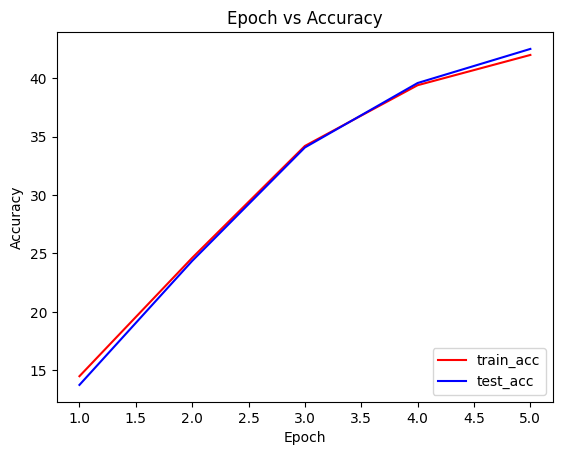

In [53]:
display(train_acc1[1], test_acc1[1])

In [16]:
train_acc_5runs = []
test_acc_5runs = []

for i in range(5):
  tr_acc, ts_acc = run_model_cifar10(32, 0.01, 0.8)
  train_acc_5runs.append(tr_acc)
  test_acc_5runs.append(ts_acc)

Files already downloaded and verified
Files already downloaded and verified
data loaded successfully...
[epoch 1, iter   200] loss: 2.259
[epoch 1, iter   400] loss: 1.960
[epoch 1, iter   600] loss: 1.736
[epoch 1, iter   800] loss: 1.628
[epoch 1, iter  1000] loss: 1.555
[epoch 1, iter  1200] loss: 1.536
[epoch 1, iter  1400] loss: 1.481
epoch 1: train_acc 48.712, test_acc 47.250
[epoch 2, iter   200] loss: 1.418
[epoch 2, iter   400] loss: 1.381
[epoch 2, iter   600] loss: 1.377
[epoch 2, iter   800] loss: 1.339
[epoch 2, iter  1000] loss: 1.355
[epoch 2, iter  1200] loss: 1.342
[epoch 2, iter  1400] loss: 1.297
epoch 2: train_acc 57.152, test_acc 54.800
[epoch 3, iter   200] loss: 1.246
[epoch 3, iter   400] loss: 1.241
[epoch 3, iter   600] loss: 1.230
[epoch 3, iter   800] loss: 1.231
[epoch 3, iter  1000] loss: 1.212
[epoch 3, iter  1200] loss: 1.213
[epoch 3, iter  1400] loss: 1.216
epoch 3: train_acc 60.900, test_acc 57.440
[epoch 4, iter   200] loss: 1.158
[epoch 4, iter   40

In [17]:
train_acc_epoch_avg = np.array(train_acc_5runs).mean(axis=0)
test_acc_epoch_avg = np.array(test_acc_5runs).mean(axis=0)
train_acc_epoch_std = np.array(train_acc_5runs).mean(axis=0)
test_acc_epoch_std = np.array(test_acc_5runs).mean(axis=0)
train_acc_max = np.max(train_acc_epoch_avg)
test_acc_max = np.max(test_acc_epoch_avg)

train_acc2 = train_acc_5runs
test_acc2 = test_acc_5runs

print("Hyperparameters: train batch size = 32, learning rate = 0.01, momentum = 0.8")
print("Training statistics:")
print(f"Mean Train accuracy: {np.mean(train_acc_epoch_avg):.3f}")
print(f"STD Train accuracy: {np.std(train_acc_epoch_avg):.3f}")
print(f"Max Train accuracy: {train_acc_max:.3f}")
print("-"*150)
print("Testing statistics:")
print(f"Mean Test accuracy: {np.mean(test_acc_epoch_avg):.3f}")
print(f"STD Test accuracy: {np.std(test_acc_epoch_avg):.3f}")
print(f"Max Test accuracy: {test_acc_max:.3f}")

Hyperparameters: train batch size = 32, learning rate = 0.01, momentum = 0.8
Training statistics:
Mean Train accuracy: 58.805
STD Train accuracy: 5.854
Max Train accuracy: 65.361
------------------------------------------------------------------------------------------------------------------------------------------------------
Testing statistics:
Mean Test accuracy: 55.692
STD Test accuracy: 4.352
Max Test accuracy: 59.818


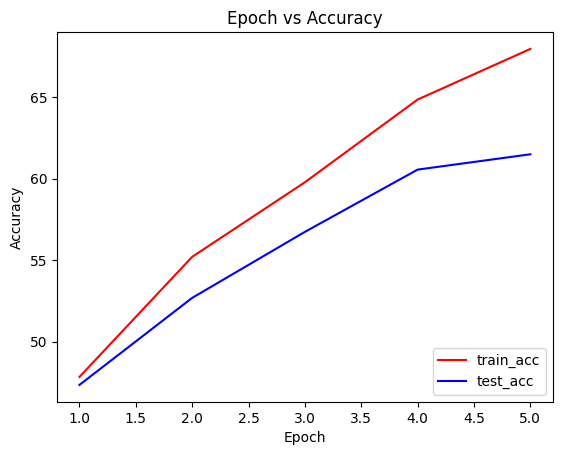

In [57]:
display(train_acc2[1], test_acc2[1])

In [24]:
train_acc_5runs = []
test_acc_5runs = []

for i in range(5):
  tr_acc, ts_acc = run_model_cifar10(64, 0.008, 0.9)
  train_acc_5runs.append(tr_acc)
  test_acc_5runs.append(ts_acc)

Files already downloaded and verified
Files already downloaded and verified
data loaded successfully...
[epoch 1, iter   200] loss: 2.125
[epoch 1, iter   400] loss: 1.776
[epoch 1, iter   600] loss: 1.611
epoch 1: train_acc 46.766, test_acc 46.490
[epoch 2, iter   200] loss: 1.452
[epoch 2, iter   400] loss: 1.393
[epoch 2, iter   600] loss: 1.359
epoch 2: train_acc 53.998, test_acc 53.110
[epoch 3, iter   200] loss: 1.266
[epoch 3, iter   400] loss: 1.252
[epoch 3, iter   600] loss: 1.224
epoch 3: train_acc 59.798, test_acc 57.580
[epoch 4, iter   200] loss: 1.156
[epoch 4, iter   400] loss: 1.149
[epoch 4, iter   600] loss: 1.141
epoch 4: train_acc 62.770, test_acc 59.560
[epoch 5, iter   200] loss: 1.070
[epoch 5, iter   400] loss: 1.067
[epoch 5, iter   600] loss: 1.079
epoch 5: train_acc 64.396, test_acc 60.270
[epoch 6, iter   200] loss: 1.010
[epoch 6, iter   400] loss: 1.005
[epoch 6, iter   600] loss: 1.028
epoch 6: train_acc 62.158, test_acc 57.660
[epoch 7, iter   200] loss

In [26]:
train_acc_epoch_avg = np.array(train_acc_5runs).mean(axis=0)
test_acc_epoch_avg = np.array(test_acc_5runs).mean(axis=0)
train_acc_epoch_std = np.array(train_acc_5runs).mean(axis=0)
test_acc_epoch_std = np.array(test_acc_5runs).mean(axis=0)
train_acc_max = np.max(train_acc_epoch_avg)
test_acc_max = np.max(test_acc_epoch_avg)

train_acc3 = train_acc_5runs
test_acc3 = test_acc_5runs

print("Hyperparameters: train batch size = 64, learning rate = 0.008, momentum = 0.9")
print("Training statistics:")
print(f"Mean Train accuracy: {np.mean(train_acc_epoch_avg):.3f}")
print(f"STD Train accuracy: {np.std(train_acc_epoch_avg):.3f}")
print(f"Max Train accuracy: {train_acc_max:.3f}")
print("-"*150)
print("Testing statistics:")
print(f"Mean Test accuracy: {np.mean(test_acc_epoch_avg):.3f}")
print(f"STD Test accuracy: {np.std(test_acc_epoch_avg):.3f}")
print(f"Max Test accuracy: {test_acc_max:.3f}")

Hyperparameters: train batch size = 64, learning rate = 0.008, momentum = 0.9
Training statistics:
Mean Train accuracy: 64.077
STD Train accuracy: 8.028
Max Train accuracy: 73.510
------------------------------------------------------------------------------------------------------------------------------------------------------
Testing statistics:
Mean Test accuracy: 58.953
STD Test accuracy: 5.214
Max Test accuracy: 63.320


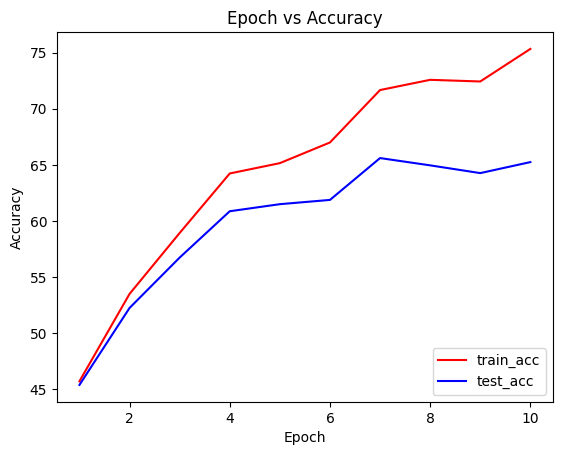

In [59]:
display(train_acc3[1], test_acc3[1])

# Q1 c) Evaluation and Ablation study

# MNIST dataset

In [78]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

In [79]:
def getPredictions(model, test_data):
  with torch.no_grad():
    true_labels = []
    predicted_labels = []
    for data in test_data:
      images, labels = data
      outputs=model(images)
      _,predicted=torch.max(outputs.data,1)
      true_labels.append(labels)
      predicted_labels.append(predicted) 

  return true_labels, predicted_labels

In [80]:
def flatten(list2d):
  temp = []
  for i in list2d:
    for j in i:
      temp.append(int(j))
  return temp

In [81]:
def getWrongPairs(model, test_data, true_val, false_val):
  with torch.no_grad():
    false_img = []
    for data in test_data:
      images, labels = data
      outputs=model(images)
      _,predicted=torch.max(outputs.data,1)
      img_idx = -1
      for i in range(len(labels)):
        if labels[i] == true_val and predicted[i] == false_val:
          false_img.append(images[i])
    
  return false_img
       

In [82]:
def dispImg(img, true_val, false_val, dataset):
  if dataset == "mnist":
    img = img * 0.3081
    img = img + 0.1307
    img = img * 255.
    img = img.byte()
  
  if dataset == "fminst":
    img = img * 0.35302
    img = img + 0.28604
    img = img * 255.
    img = img.byte()

  pixels = img.reshape((28,28))
  plt.imshow(pixels, cmap='gray')
  plt.title(f"{true_val} classified as {false_val}")
  plt.show()

In [83]:
def dispImgCIFAR10(img, true_val, false_val):
  img2 = torch.empty((3,32,32))
  img2[0] = img[0] * 0.2470
  img2[1] = img[1] * 0.2435
  img2[2] = img[2] * 0.2616

  img2[0] = img2[0] + 0.4914
  img2[1] = img2[1] + 0.4822
  img2[2] = img2[2] + 0.4465

  image = TF.to_pil_image(img2)
  plt.figure()
  plt.title(f"{true_val} classified as {false_val}")
  plt.imshow(image)

In [84]:
train_loader, test_loader = load_data(32, 1000)

100%|██████████| 9912422/9912422 [00:00<00:00, 130330566.09it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 33251631.57it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 45822150.79it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 13093146.92it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

data loaded successfully...


In [85]:
# training the model with best parameters
# learning rate = 0.01
# train batch size = 32
# momentum = 0.8

net=Net()

# training
learning_rate=0.01
momentum=0.8
max_epoch=5
criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(net.parameters(),lr=learning_rate,momentum=momentum)

for epoch in range(max_epoch):
    train(train_loader, test_loader, net, criterion, optimizer,epoch)


[epoch 1, iter   200] loss: 1.268
[epoch 1, iter   400] loss: 0.311
[epoch 1, iter   600] loss: 0.188
[epoch 1, iter   800] loss: 0.133
[epoch 1, iter  1000] loss: 0.133
[epoch 1, iter  1200] loss: 0.120
[epoch 1, iter  1400] loss: 0.092
[epoch 1, iter  1600] loss: 0.103
[epoch 1, iter  1800] loss: 0.089
epoch 1: train_acc 97.935, test_acc 97.780
[epoch 2, iter   200] loss: 0.061
[epoch 2, iter   400] loss: 0.069
[epoch 2, iter   600] loss: 0.056
[epoch 2, iter   800] loss: 0.073
[epoch 2, iter  1000] loss: 0.070
[epoch 2, iter  1200] loss: 0.066
[epoch 2, iter  1400] loss: 0.062
[epoch 2, iter  1600] loss: 0.067
[epoch 2, iter  1800] loss: 0.054
epoch 2: train_acc 98.808, test_acc 98.590
[epoch 3, iter   200] loss: 0.045
[epoch 3, iter   400] loss: 0.046
[epoch 3, iter   600] loss: 0.044
[epoch 3, iter   800] loss: 0.047
[epoch 3, iter  1000] loss: 0.055
[epoch 3, iter  1200] loss: 0.038
[epoch 3, iter  1400] loss: 0.049
[epoch 3, iter  1600] loss: 0.045
[epoch 3, iter  1800] loss: 0.

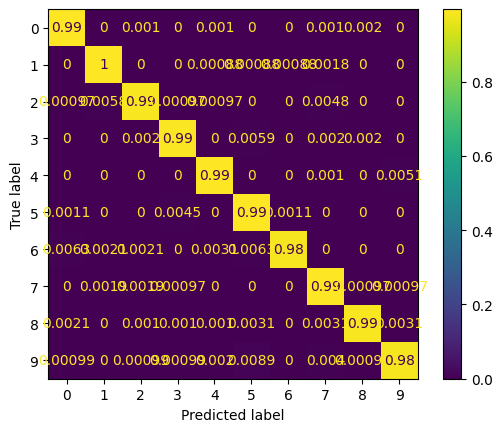

In [93]:
labels, preds = getPredictions(net, test_loader)

true_labels = flatten(labels)
predictions = flatten(preds)

cm = confusion_matrix(true_labels, predictions, labels=[0,1,2,3,4,5,6,7,8,9], normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4,5,6,7,8,9])
disp.plot()
plt.show()

In [ ]:
# Top 3 confused pairs
# 2 classified as 1 
# 2 classified as 7
# 3 classified as 5

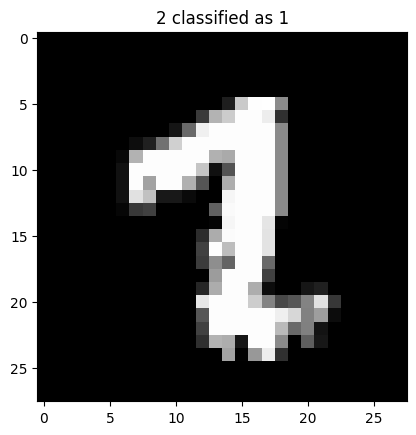

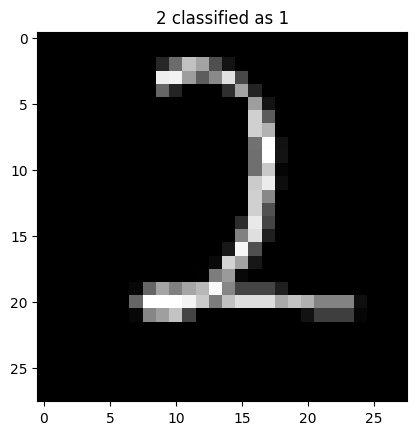

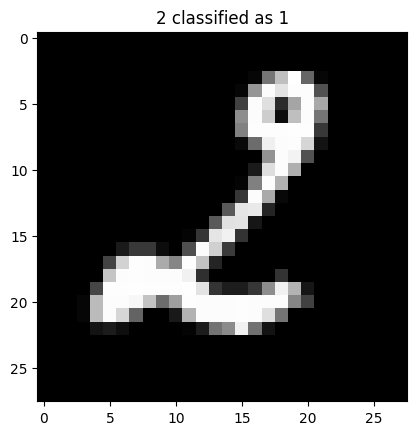

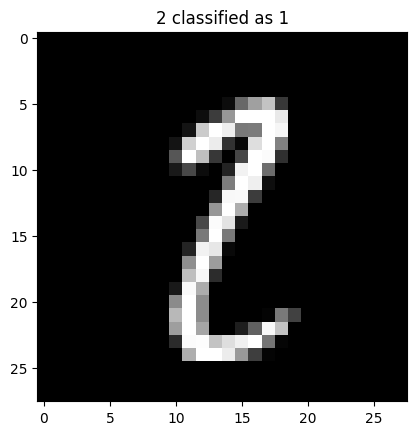

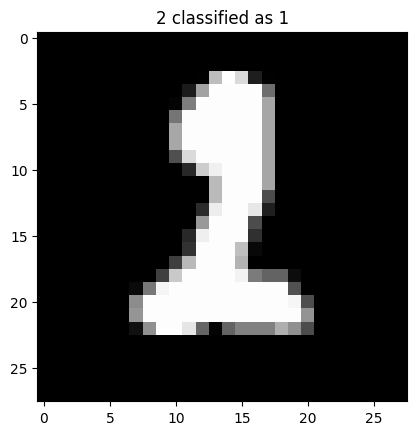

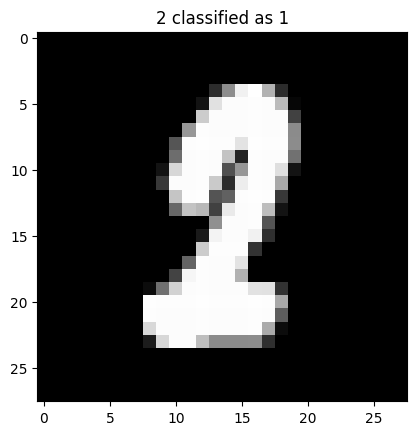

In [94]:
imgs = getWrongPairs(net, test_loader, 2, 1)
for img in imgs:
  dispImg(img, 2, 1, "mnist")

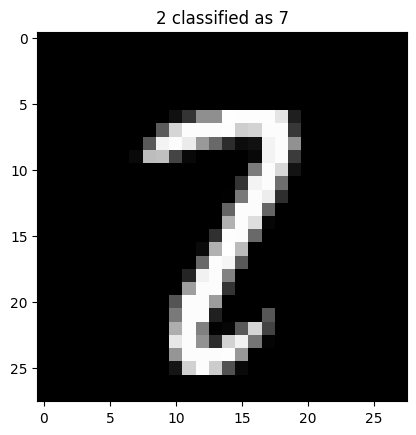

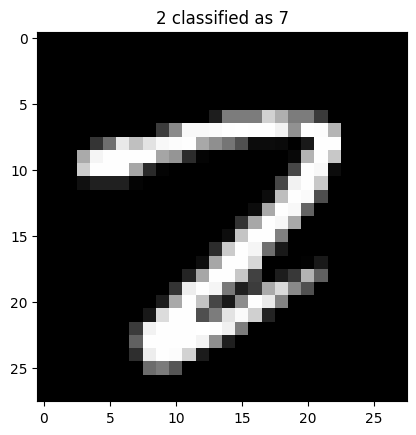

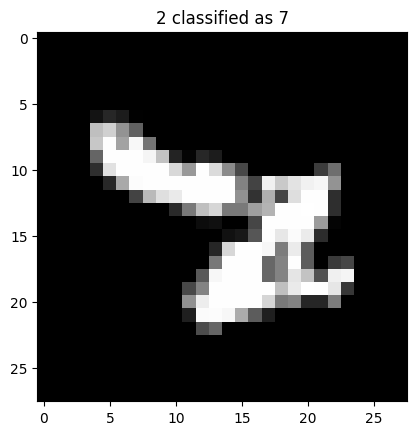

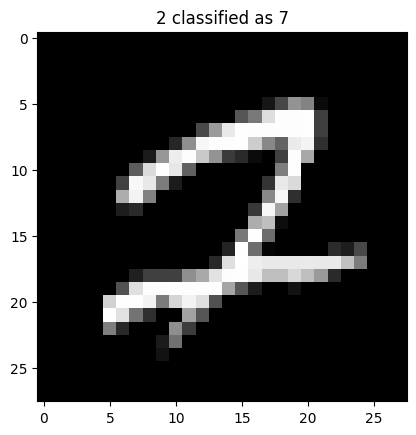

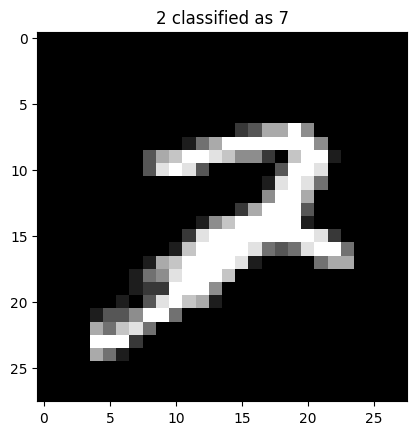

In [95]:
imgs = getWrongPairs(net, test_loader, 2, 7)
for img in imgs:
  dispImg(img, 2, 7, "mnist")

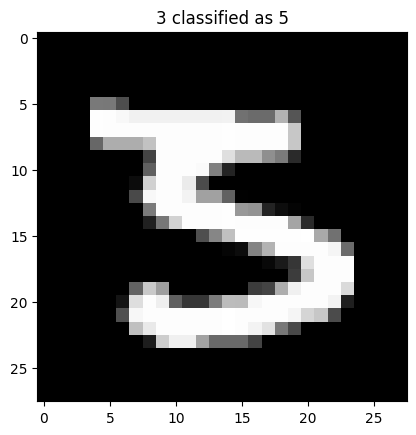

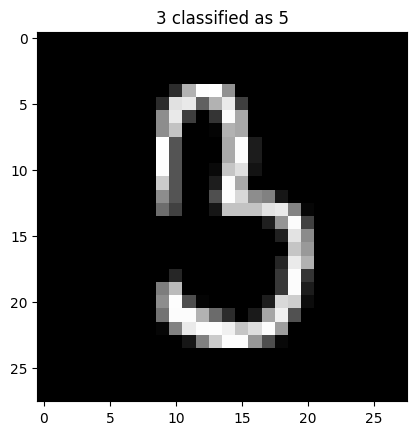

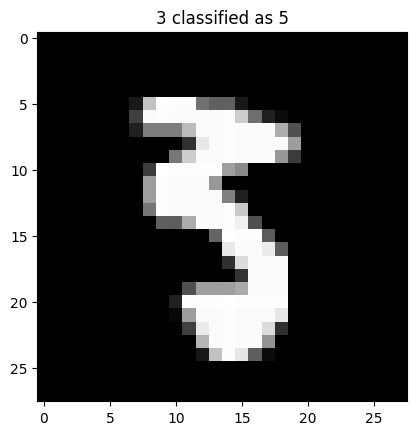

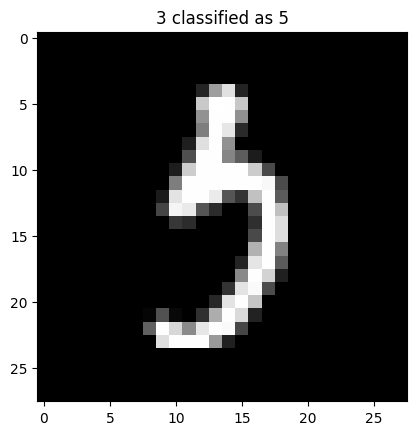

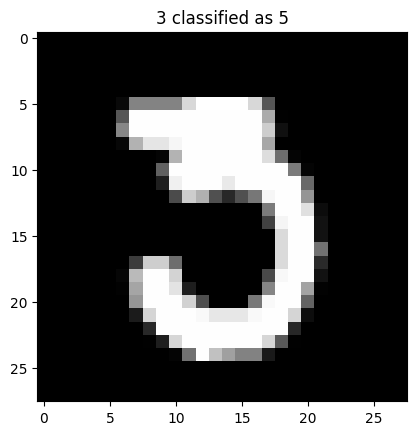

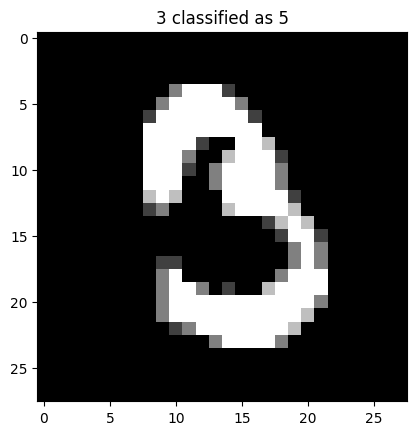

In [96]:
imgs = getWrongPairs(net, test_loader, 3, 5)
for img in imgs:
  dispImg(img, 3, 5, "mnist")

# Fashion MNIST dataset

In [97]:
train_loader, test_loader = load_data_fashion_mnist(32, 1000)

100%|██████████| 26421880/26421880 [00:02<00:00, 12243027.21it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 210051.11it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3933544.98it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 8062836.82it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

data loaded successfully...


In [98]:
# training the model with best parameters
# learning rate = 0.01
# train batch size = 32
# momentum = 0.8

net=Net()

# training
learning_rate=0.01
momentum=0.8
max_epoch=5
criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(net.parameters(),lr=learning_rate,momentum=momentum)

for epoch in range(max_epoch):
    train(train_loader, test_loader, net, criterion, optimizer,epoch)

[epoch 1, iter   200] loss: 1.445
[epoch 1, iter   400] loss: 0.767
[epoch 1, iter   600] loss: 0.652
[epoch 1, iter   800] loss: 0.550
[epoch 1, iter  1000] loss: 0.526
[epoch 1, iter  1200] loss: 0.499
[epoch 1, iter  1400] loss: 0.470
[epoch 1, iter  1600] loss: 0.448
[epoch 1, iter  1800] loss: 0.416
epoch 1: train_acc 86.358, test_acc 85.300
[epoch 2, iter   200] loss: 0.390
[epoch 2, iter   400] loss: 0.388
[epoch 2, iter   600] loss: 0.375
[epoch 2, iter   800] loss: 0.356
[epoch 2, iter  1000] loss: 0.362
[epoch 2, iter  1200] loss: 0.369
[epoch 2, iter  1400] loss: 0.350
[epoch 2, iter  1600] loss: 0.337
[epoch 2, iter  1800] loss: 0.357
epoch 2: train_acc 88.880, test_acc 87.740
[epoch 3, iter   200] loss: 0.324
[epoch 3, iter   400] loss: 0.318
[epoch 3, iter   600] loss: 0.329
[epoch 3, iter   800] loss: 0.317
[epoch 3, iter  1000] loss: 0.306
[epoch 3, iter  1200] loss: 0.317
[epoch 3, iter  1400] loss: 0.305
[epoch 3, iter  1600] loss: 0.299
[epoch 3, iter  1800] loss: 0.

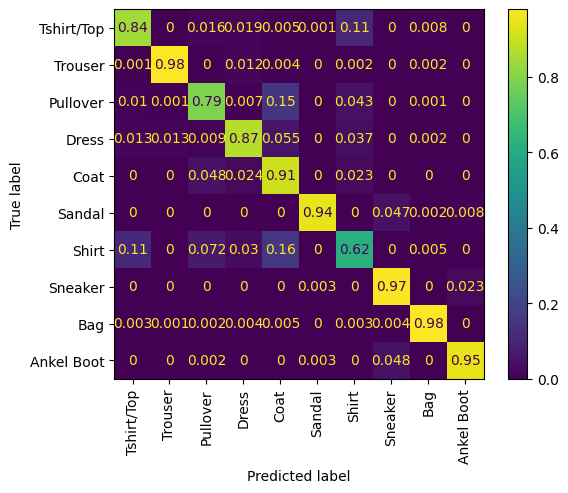

In [99]:
labels, preds = getPredictions(net, test_loader)
true_labels = flatten(labels)
predictions = flatten(preds)

cm = confusion_matrix(true_labels, predictions, labels=[0,1,2,3,4,5,6,7,8,9], normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Tshirt/Top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankel Boot"])
disp.plot(xticks_rotation='vertical')
plt.show()



In [ ]:
# Top 3 confused pairs
# Tshirt/Top classified as Shirt (0 - 6)
# Shirt classifies as Coat       (6 - 4)
# Pullover classified as Coat    (2 - 4)

106 Shirt images were classified as Tshirt/Top



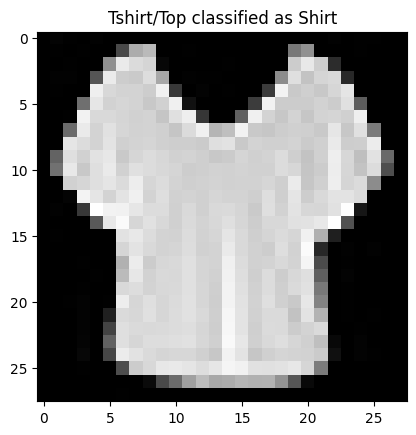

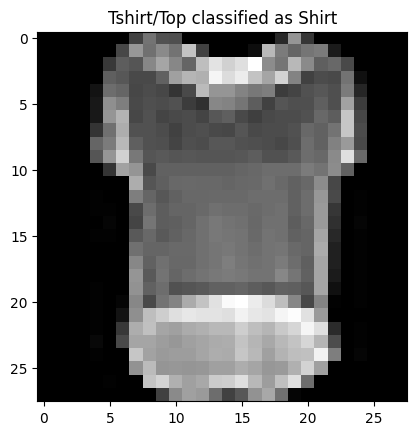

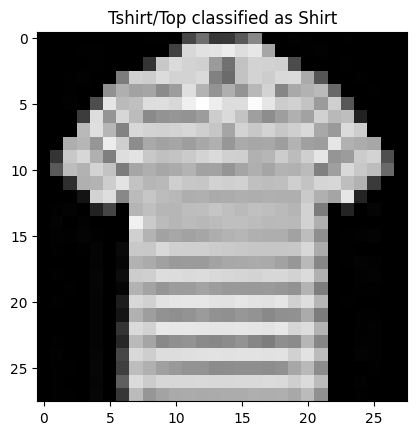

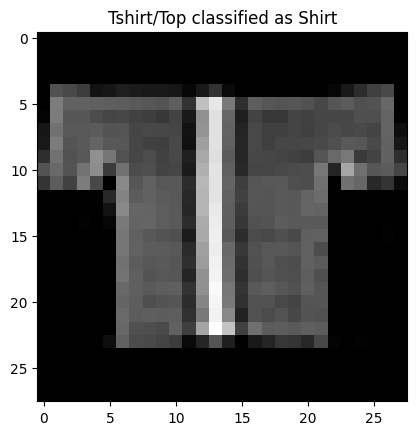

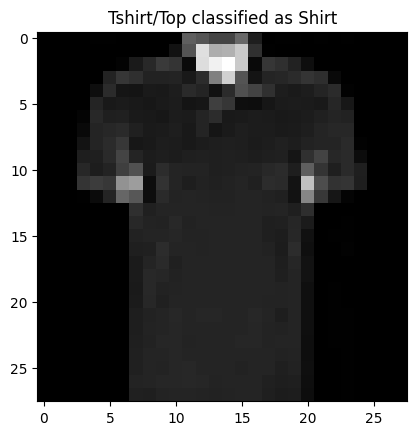

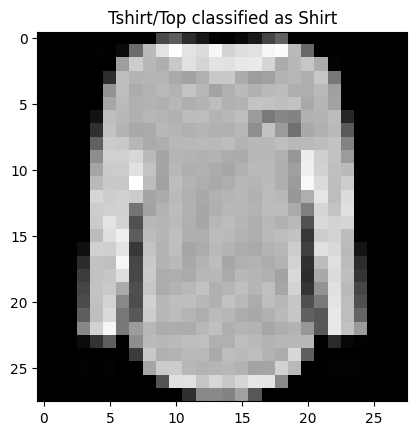

In [101]:
imgs = getWrongPairs(net, test_loader, 0, 6)
print(f"{len(imgs)} Shirt images were classified as Tshirt/Top\n")
count = 0
for img in imgs:
  dispImg(img, "Tshirt/Top", "Shirt", "fmnist")
  print()
  count += 1
  if count > 5:
    break



137 Shirt images were classified as Coats



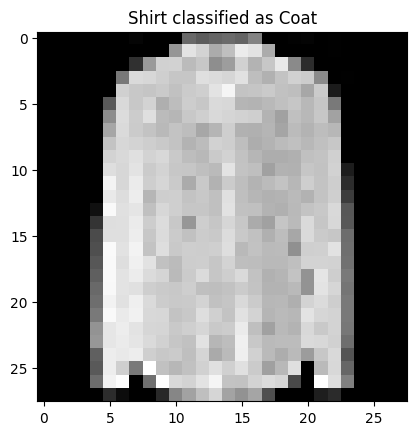

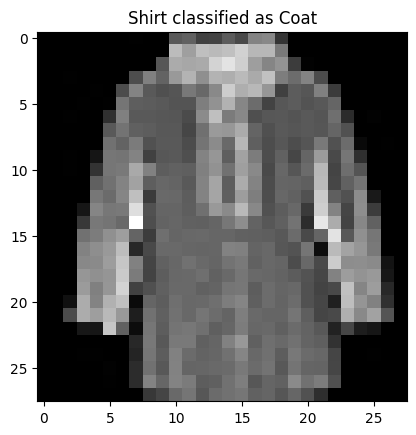

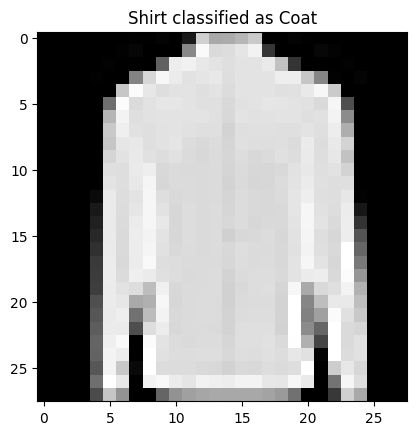

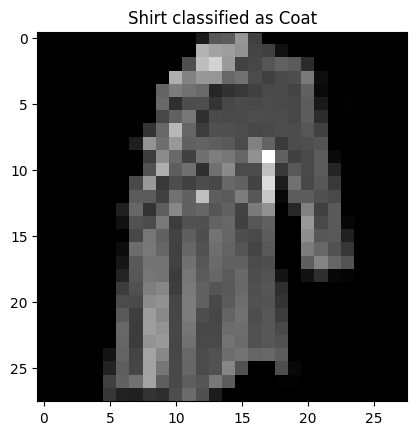

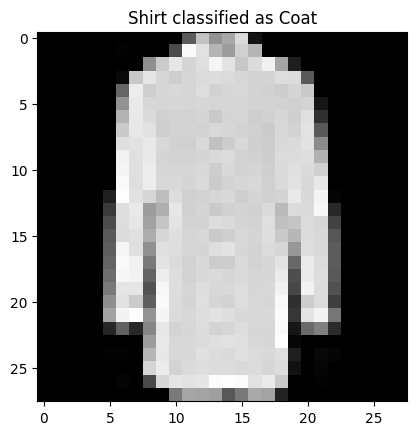

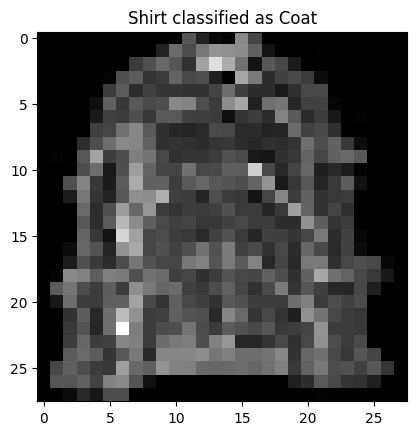

In [23]:
imgs = getWrongPairs(net, test_loader, 6, 4)
print(f"{len(imgs)} Shirt images were classified as Coats\n")
count = 0
for img in imgs:
  dispImg(img, "Shirt", "Coat", "fmnist")
  print()
  count += 1
  if count > 5:
    break

103 Pullover images were classified as Coats



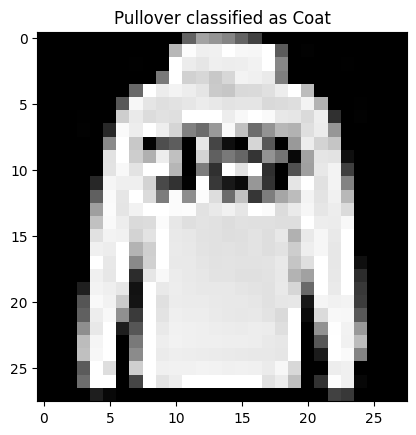

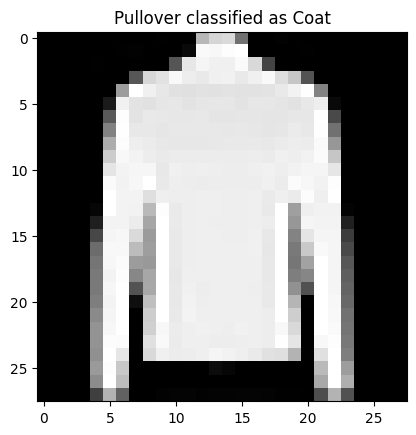

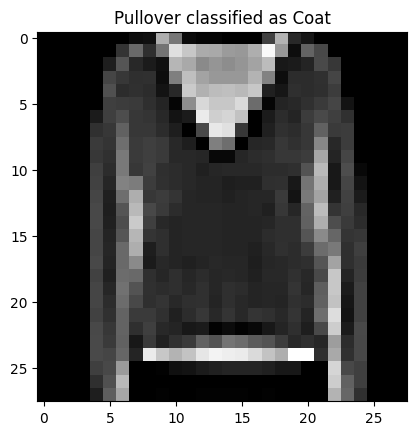

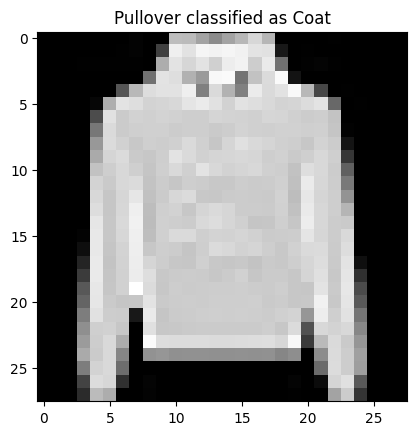

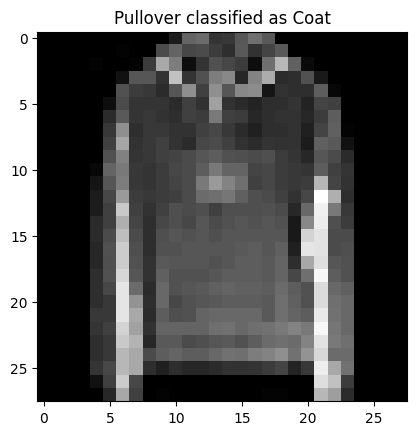

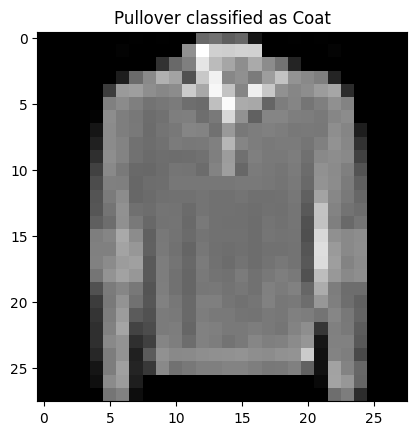

In [24]:
imgs = getWrongPairs(net, test_loader, 2, 4)
print(f"{len(imgs)} Pullover images were classified as Coats\n")
count = 0
for img in imgs:
  dispImg(img, "Pullover", "Coat", "fmnist")
  print()
  count += 1
  if count > 5:
    break

# CIFAR 10 dataset

In [25]:
train_loader, test_loader = load_data_cifar10(64, 1000)

100%|██████████| 170498071/170498071 [00:03<00:00, 42895206.36it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
data loaded successfully...


In [38]:
# training the model with best parameters
# learning rate = 0.008
# train batch size = 64
# momentum = 0.9

# new model
net=Net_CIFAR10()

# training
learning_rate=0.008
momentum=0.9
max_epoch=10
criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(net.parameters(),lr=learning_rate,momentum=momentum)


for epoch in range(max_epoch):
    train(train_loader, test_loader, net, criterion, optimizer,epoch)
    

[epoch 1, iter   200] loss: 2.173
[epoch 1, iter   400] loss: 1.793
[epoch 1, iter   600] loss: 1.622
epoch 1: train_acc 48.284, test_acc 47.470
[epoch 2, iter   200] loss: 1.433
[epoch 2, iter   400] loss: 1.371
[epoch 2, iter   600] loss: 1.354
epoch 2: train_acc 52.948, test_acc 51.670
[epoch 3, iter   200] loss: 1.239
[epoch 3, iter   400] loss: 1.255
[epoch 3, iter   600] loss: 1.205
epoch 3: train_acc 59.126, test_acc 57.170
[epoch 4, iter   200] loss: 1.139
[epoch 4, iter   400] loss: 1.147
[epoch 4, iter   600] loss: 1.132
epoch 4: train_acc 63.072, test_acc 59.540
[epoch 5, iter   200] loss: 1.055
[epoch 5, iter   400] loss: 1.078
[epoch 5, iter   600] loss: 1.074
epoch 5: train_acc 64.416, test_acc 60.420
[epoch 6, iter   200] loss: 0.989
[epoch 6, iter   400] loss: 1.012
[epoch 6, iter   600] loss: 1.007
epoch 6: train_acc 64.558, test_acc 59.350
[epoch 7, iter   200] loss: 0.932
[epoch 7, iter   400] loss: 0.965
[epoch 7, iter   600] loss: 0.959
epoch 7: train_acc 65.634, t

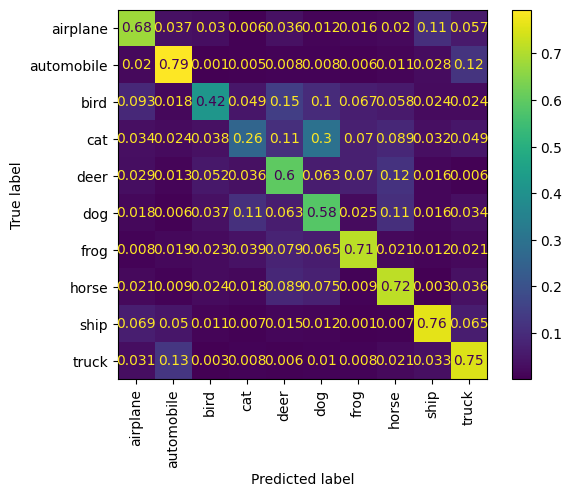

In [39]:
labels, preds = getPredictions(net, test_loader)
true_labels = flatten(labels)
predictions = flatten(preds)

cm = confusion_matrix(true_labels, predictions, labels=[0,1,2,3,4,5,6,7,8,9], normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"])
disp.plot(xticks_rotation='vertical')
plt.show()

In [ ]:
# Top 3 confused pairs
# Cat classified as Dog (3 - 5)
# Truck classified as Automobile (9 - 1)
# Bird classified as Deer (2 - 4)

297 Cat images were classified as Dogs


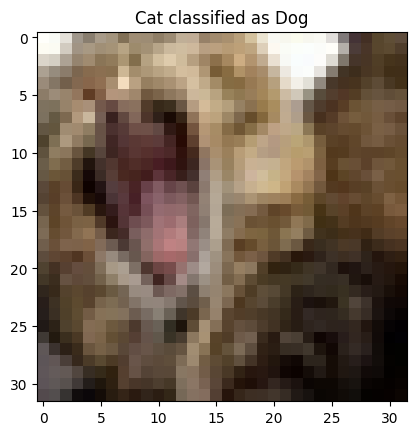

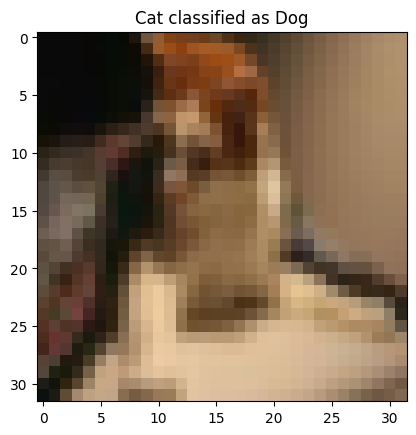

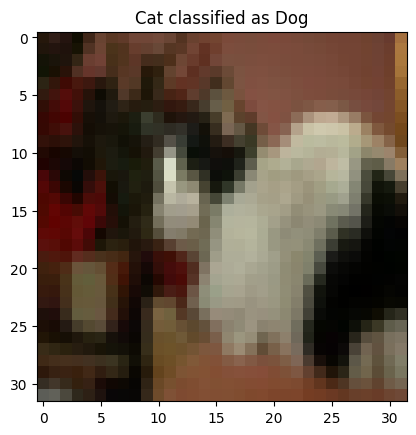

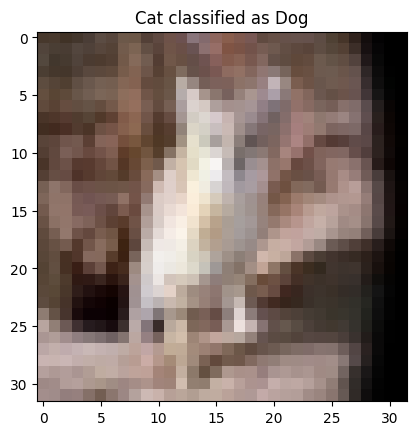

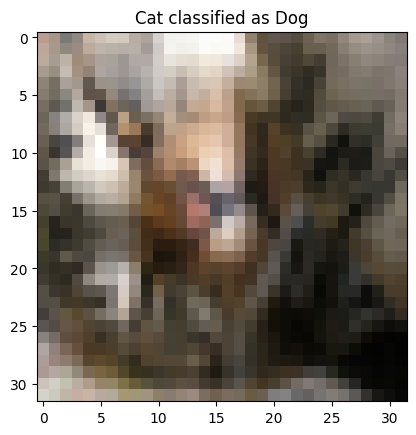

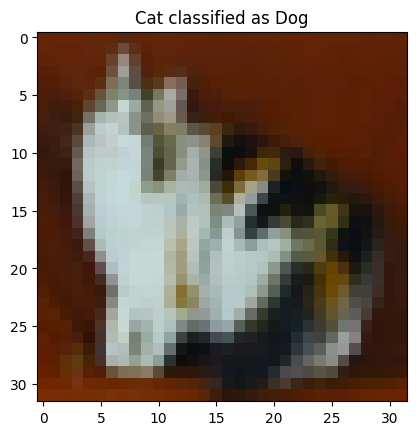

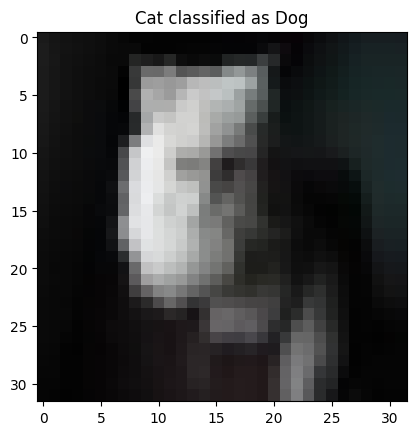

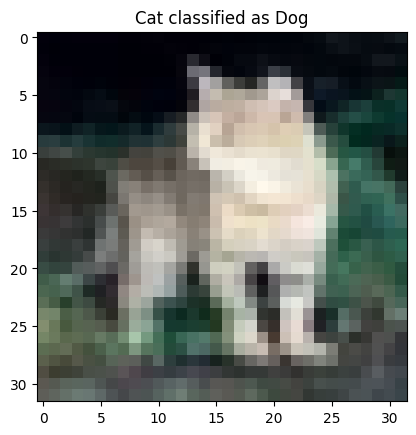

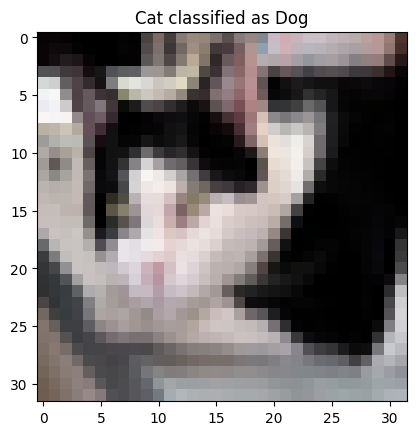

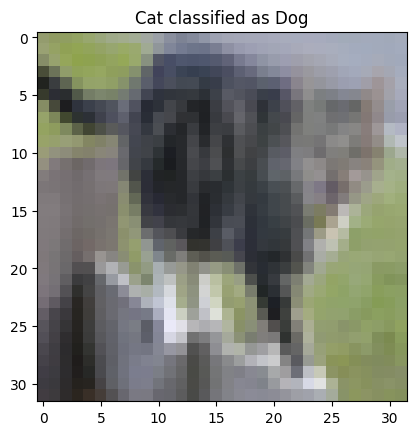

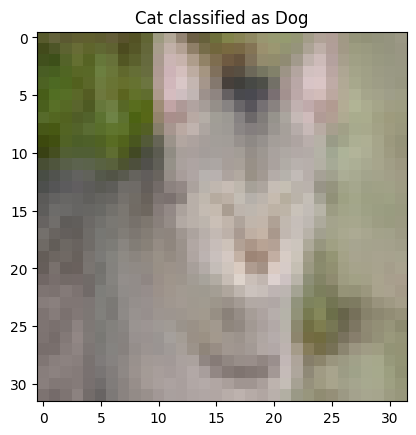

In [40]:
imgs = getWrongPairs(net, test_loader, 3, 5)
print(f"{len(imgs)} Cat images were classified as Dogs")
count = 0
for img in imgs:
  dispImgCIFAR10(img, "Cat", "Dog")
  count += 1
  if count > 10:
    break



127 Truck images were classified as Automobile


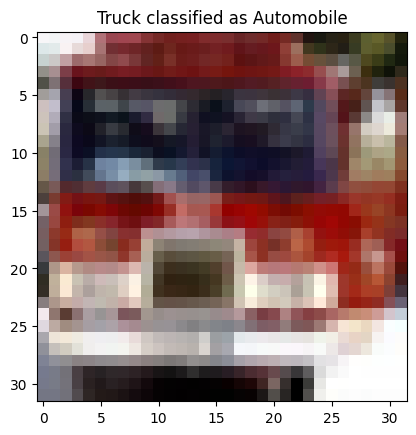

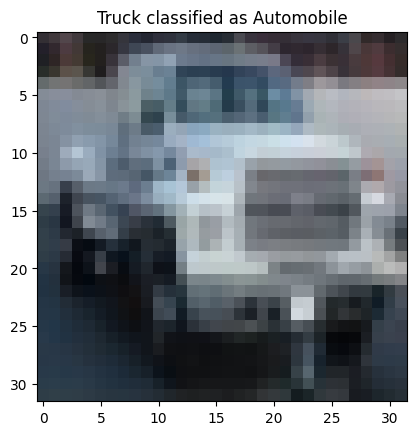

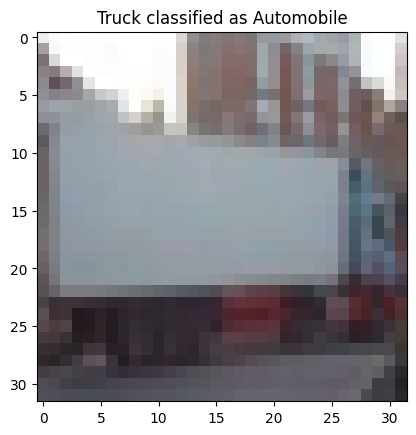

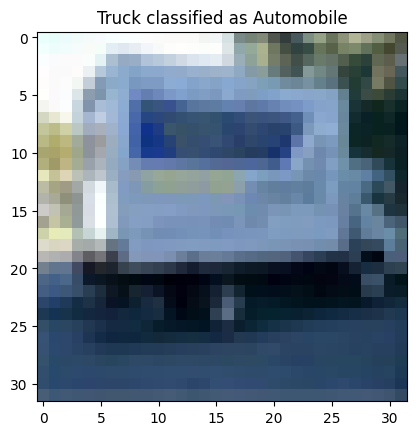

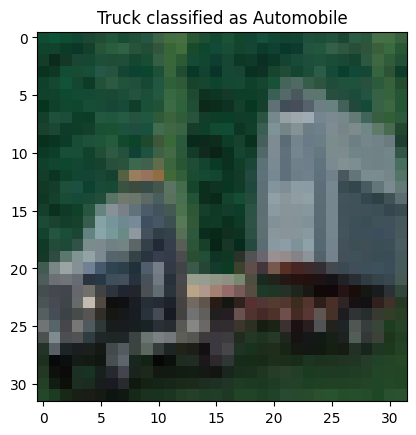

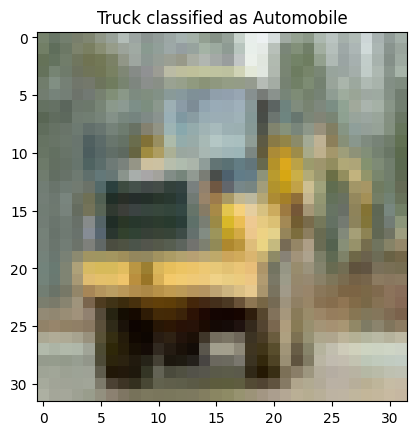

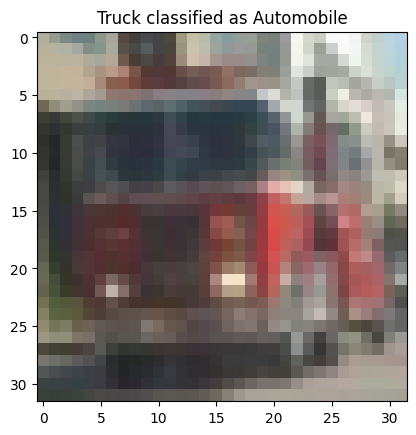

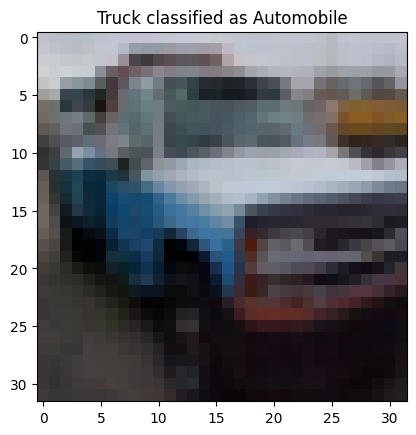

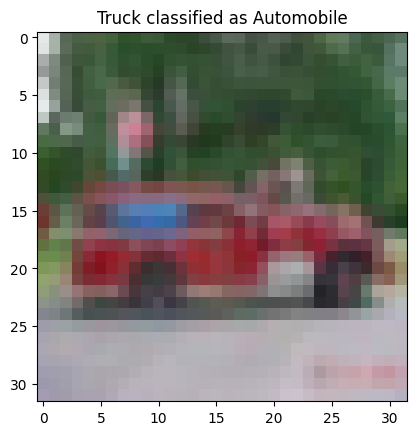

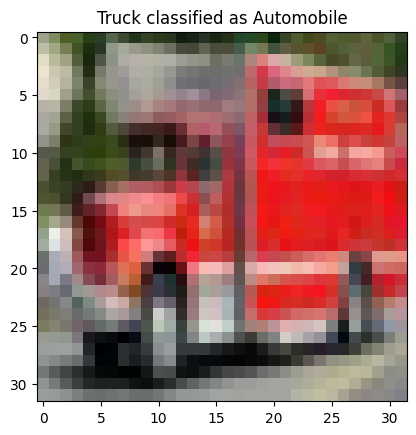

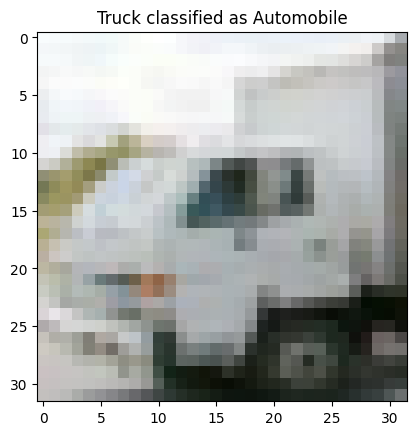

In [41]:
imgs = getWrongPairs(net, test_loader, 9, 1)
print(f"{len(imgs)} Truck images were classified as Automobile")
count = 0
for img in imgs:
  dispImgCIFAR10(img, "Truck", "Automobile")
  count += 1
  if count > 10:
    break

148 Bird images were classified as Deer


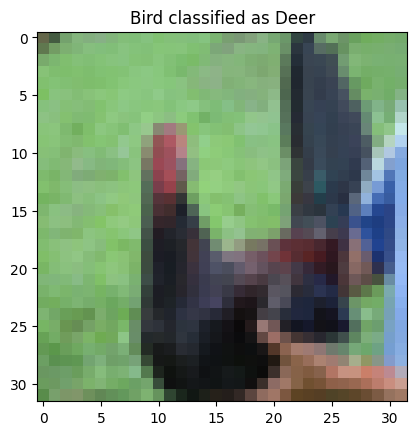

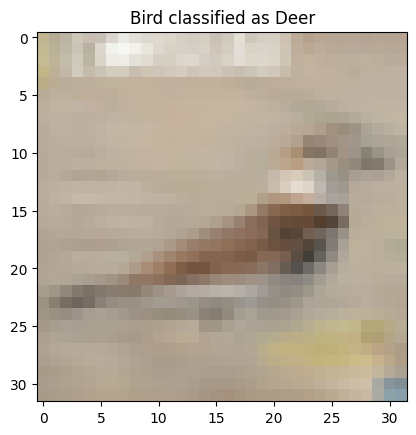

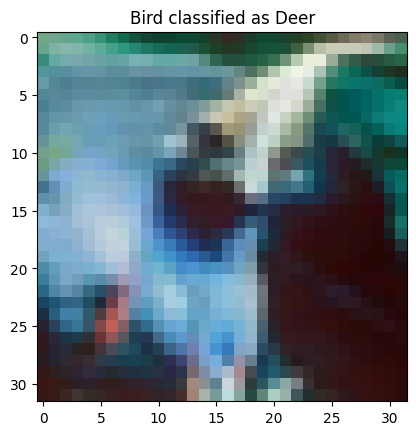

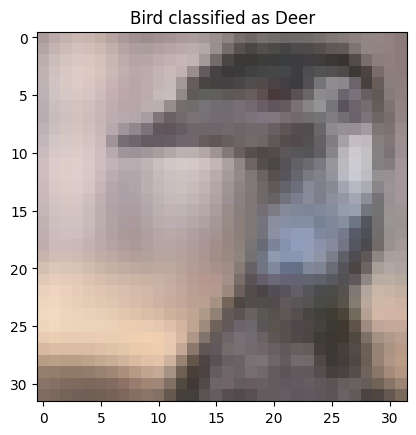

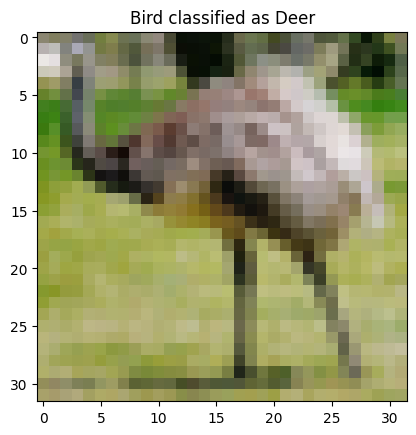

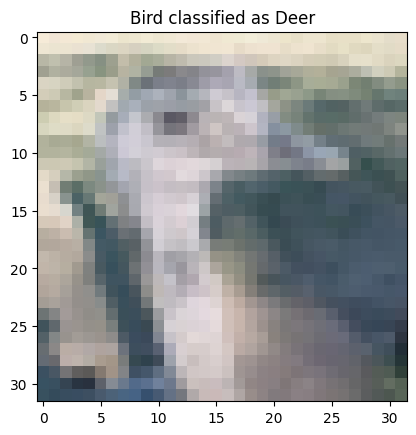

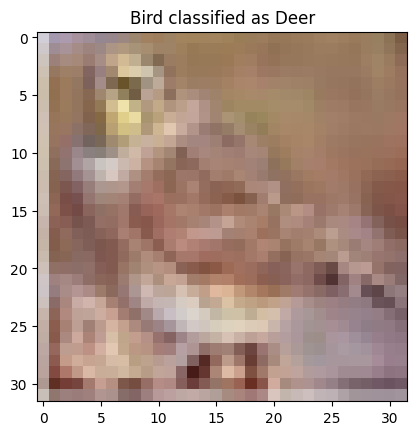

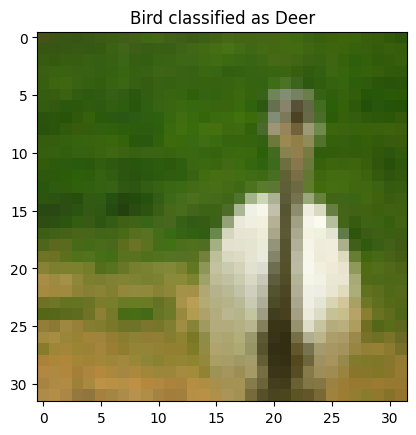

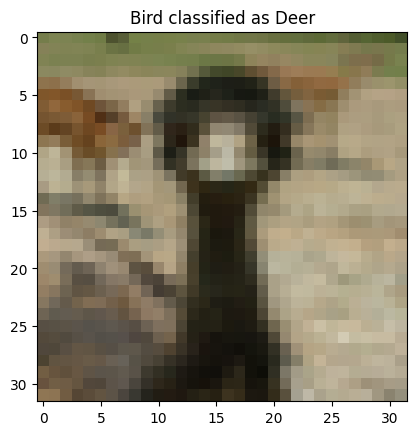

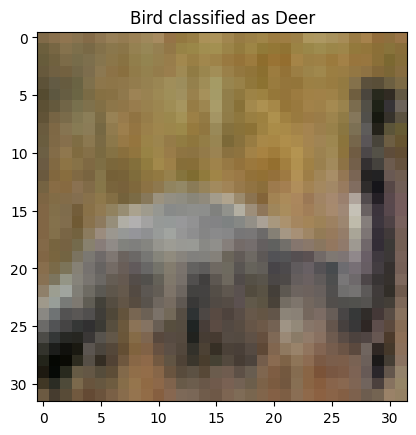

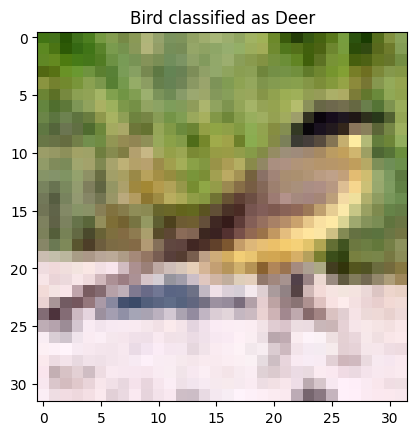

In [42]:
imgs = getWrongPairs(net, test_loader, 2, 4)
print(f"{len(imgs)} Bird images were classified as Deer")
count = 0
for img in imgs:
  dispImgCIFAR10(img, "Bird", "Deer")
  count += 1
  if count > 10:
    break

#Q1 c 2: plotting ROC curves

In [183]:
def plotROCCruve(class_idx, transformed_labels, output_probs):

  probs = []
  for i in range(len(output_probs)):
    temp = F.softmax(output_probs[i][:,class_idx], dim=0)
    temp = temp.tolist()
    probs.extend(temp)

  fpr, tpr, _ = roc_curve(transformed_labels[:,class_idx], probs)
  roc_auc = auc(fpr, tpr)
  plt.figure()
  RocCurveDisplay.from_predictions(transform_label[:,class_idx], probs, name=f"{class_idx} vs the rest", color="darkorange")
  plt.plot([0, 1], [0, 1], 'k--', label="chance level (AUC = 0.5)")
  plt.axis("square")
  plt.xlabel("False positive rate")
  plt.ylabel("True positive rate")
  plt.title(f"ROC curve, class {class_idx} vs Rest")
  plt.legend()
  plt.show()

  return roc_auc

In [170]:
# getting CNN outputs for each test images
output_probs = []
with torch.no_grad():
  for data in test_loader:
    images, labels = data
    outputs=net(images)
    output_probs.append(outputs)

# getting the labels of all the train images
temp = []
for data in train_loader:
  _, labels = data
  temp.append(labels)

train_labels = flatten(temp)

# tranforming the labels in a one hot coded way because ROC is used with binary classification 
# one hot encoding the multiclass labels tranforms it into one vs rest classifiction
label_binarizer = LabelBinarizer().fit(train_labels)
transform_label = label_binarizer.transform(true_labels)

<Figure size 640x480 with 0 Axes>

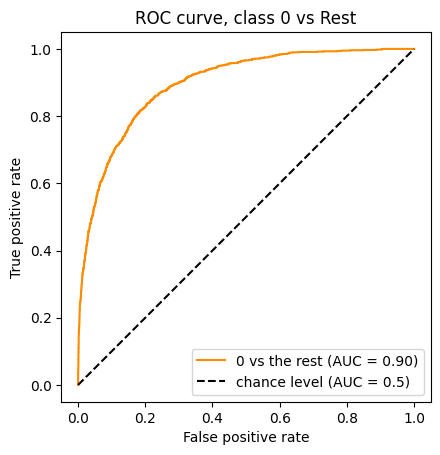

<Figure size 640x480 with 0 Axes>

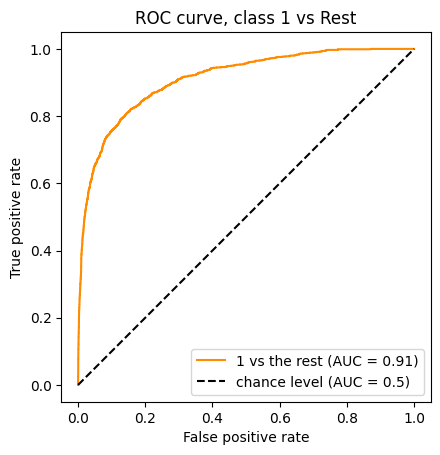

<Figure size 640x480 with 0 Axes>

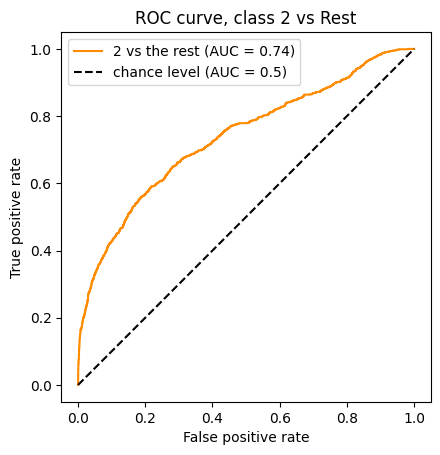

<Figure size 640x480 with 0 Axes>

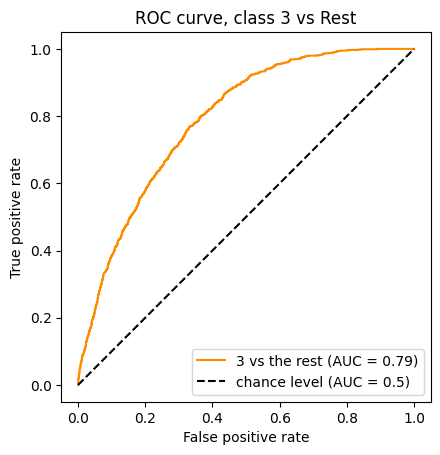

<Figure size 640x480 with 0 Axes>

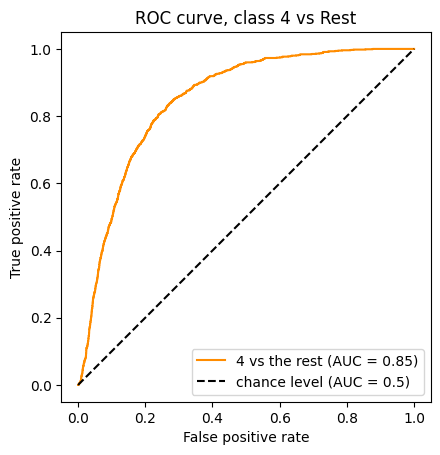

<Figure size 640x480 with 0 Axes>

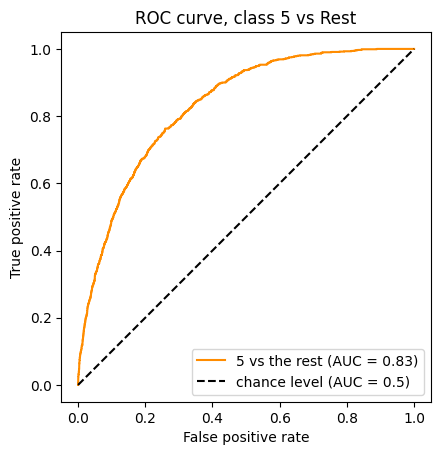

<Figure size 640x480 with 0 Axes>

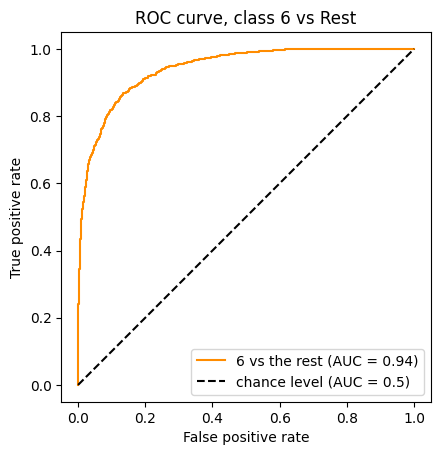

<Figure size 640x480 with 0 Axes>

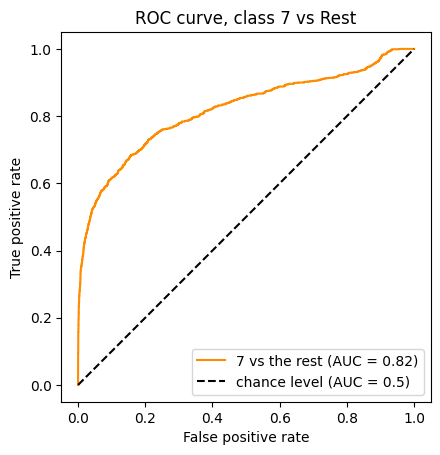

<Figure size 640x480 with 0 Axes>

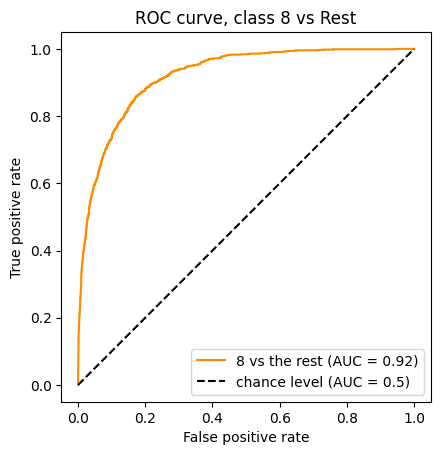

<Figure size 640x480 with 0 Axes>

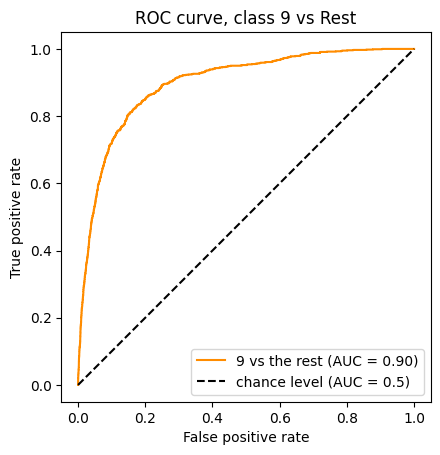

In [184]:
roc_auc = []
for i in range(10):
  temp = plotROCCruve(i, transform_label, output_probs)
  roc_auc.append(temp)
  print()

In [185]:
roc_auc

[0.8965671111111112,
 0.9109940000000001,
 0.7362815555555555,
 0.7897602222222222,
 0.8476486666666667,
 0.8304432222222221,
 0.9419877777777778,
 0.8184359999999999,
 0.9199746666666666,
 0.8975497777777778]

In [192]:
for i in [0,1,2,3,4,5,6,7,8,9]:
  print(f"count of class {i}: {true_labels.count(i)}")

count of class 0: 1000
count of class 1: 1000
count of class 2: 1000
count of class 3: 1000
count of class 4: 1000
count of class 5: 1000
count of class 6: 1000
count of class 7: 1000
count of class 8: 1000
count of class 9: 1000


In [195]:
avg_auc = np.mean(roc_auc)
print(f"The avrage AUC for CIFAR10 dataset is: {avg_auc:.3f}")

The avrage AUC for CIFAR10 dataset is: 0.859


#Q1 d) Classification with noisy data

In [20]:
def load_data_fashion_mnist2(train_batch_size, test_batch_size):
    transform=transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize((0.28604,), (0.35302,))])
    train_set=tv.datasets.FashionMNIST(
        root='./data',
        train=True,
        download=True,
        transform=transform
        )
    train_loader=torch.utils.data.DataLoader(
        train_set,
        batch_size=train_batch_size,
        shuffle=False,
        num_workers=2)
    test_set=tv.datasets.FashionMNIST(
        root='./data',
        train=False,
        download=True,
        transform=transform
        )
    test_loader=torch.utils.data.DataLoader(
        test_set,
        batch_size=test_batch_size,
        shuffle=False,
        num_workers=2)
    print("data loaded successfully...")
    return train_loader,test_loader

In [41]:
def add_SLN(labels, noise):
  noisy_labels = labels.clone().detach()
  num_samples = int(len(labels) * noise)
  random_idxs = random.sample(range(60000), num_samples)
  
  for i in random_idxs:
    temp = np.random.randint(0, 10)
    while noisy_labels[i] == temp:
      temp = np.random.randint(0, 10)
    noisy_labels[i] = temp
  

  return noisy_labels



In [22]:
def load_data_with_noise(train_batch_size, test_batch_size, noise):
  transform=transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize((0.28604,), (0.35302,))])
  train_set=tv.datasets.FashionMNIST(
      root='./data',
      train=True,
      download=True,
      transform=transform
      )
  
  train_labels = train_set.targets
  noisy_labels = add_SLN(train_labels, noise)
  train_set.targets = noisy_labels
  new_labels = train_set.targets

  train_loader=torch.utils.data.DataLoader(
    train_set,
    batch_size=train_batch_size,
    shuffle=True,
    num_workers=2)

  test_set=tv.datasets.FashionMNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
    )
  test_loader=torch.utils.data.DataLoader(
      test_set,
      batch_size=test_batch_size,
      shuffle=False,
      num_workers=2)
  print("data loaded successfully...")

  return train_labels, new_labels, train_loader, test_loader

data loaded successfully...


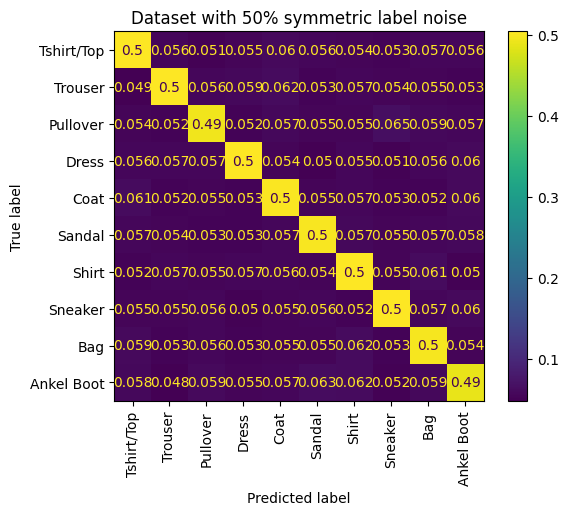

In [42]:
ori_labels, mod_labels, train_set, test_set = load_data_with_noise(32, 1000, 0.50)

test_accuracies = []

cm = confusion_matrix(ori_labels, mod_labels, labels=[0,1,2,3,4,5,6,7,8,9], normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Tshirt/Top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankel Boot"])
disp.plot(xticks_rotation='vertical')
plt.title("Dataset with 50% symmetric label noise")
plt.show()

In [36]:
def execute_model(train_loader, test_loader):
  # new model
  net=Net()

  # training
  learning_rate=0.01
  momentum=0.8
  max_epoch=5
  criterion=nn.CrossEntropyLoss()
  optimizer=optim.SGD(net.parameters(),lr=learning_rate,momentum=momentum)

  train_acc=[]
  test_acc=[]
  for epoch in range(max_epoch):
      train_acc_t,test_acc_t=train(train_loader, test_loader, net, criterion, optimizer,epoch)
      train_acc.append(train_acc_t)
      test_acc.append(test_acc_t)
    
  return train_acc, test_acc

In [ ]:
ori_labels, mod_labels, train_set, test_set = load_data_with_noise(32, 1000, 0)

test_acc_5runs = []

for i in range(5):
  tr_acc, ts_acc = execute_model(train_set, test_set)
  test_acc_5runs.append(ts_acc)

In [46]:
test_acc_epoch_avg = np.array(test_acc_5runs).mean(axis=0)
test_acc_epoch_std = np.array(test_acc_5runs).mean(axis=0)

print(f"Mean Test accuracy: {np.mean(test_acc_epoch_avg):.3f}")
print(f"STD Test accuracy: {np.std(test_acc_epoch_avg):.3f}")

Mean Test accuracy: 87.531
STD Test accuracy: 1.579


In [ ]:
ori_labels, mod_labels, train_set, test_set = load_data_with_noise(32, 1000, 0.20)

test_acc_5runs = []

for i in range(5):
  tr_acc, ts_acc = execute_model(train_set, test_set)
  test_acc_5runs.append(ts_acc)

In [ ]:
test_acc_epoch_avg = np.array(test_acc_5runs).mean(axis=0)
test_acc_epoch_std = np.array(test_acc_5runs).mean(axis=0)

print(f"Mean Test accuracy: {np.mean(test_acc_epoch_avg):.3f}")
print(f"STD Test accuracy: {np.std(test_acc_epoch_avg):.3f}")

In [ ]:
ori_labels, mod_labels, train_set, test_set = load_data_with_noise(32, 1000, 0.40)

test_acc_5runs = []

for i in range(5):
  tr_acc, ts_acc = execute_model(train_set, test_set)
  test_acc_5runs.append(ts_acc)

In [ ]:
test_acc_epoch_avg = np.array(test_acc_5runs).mean(axis=0)
test_acc_epoch_std = np.array(test_acc_5runs).mean(axis=0)

print(f"Mean Test accuracy: {np.mean(test_acc_epoch_avg):.3f}")
print(f"STD Test accuracy: {np.std(test_acc_epoch_avg):.3f}")

In [ ]:
ori_labels, mod_labels, train_set, test_set = load_data_with_noise(32, 1000, 0.60)

test_acc_5runs = []

for i in range(5):
  tr_acc, ts_acc = execute_model(train_set, test_set)
  test_acc_5runs.append(ts_acc)

In [ ]:
test_acc_epoch_avg = np.array(test_acc_5runs).mean(axis=0)
test_acc_epoch_std = np.array(test_acc_5runs).mean(axis=0)

print(f"Mean Test accuracy: {np.mean(test_acc_epoch_avg):.3f}")
print(f"STD Test accuracy: {np.std(test_acc_epoch_avg):.3f}")

In [ ]:
ori_labels, mod_labels, train_set, test_set = load_data_with_noise(32, 1000, 0.80)

test_acc_5runs = []

for i in range(5):
  tr_acc, ts_acc = execute_model(train_set, test_set)
  test_acc_5runs.append(ts_acc)

In [48]:
test_acc_epoch_avg = np.array(test_acc_5runs).mean(axis=0)
test_acc_epoch_std = np.array(test_acc_5runs).mean(axis=0)

print(f"Mean Test accuracy: {np.mean(test_acc_epoch_avg):.3f}")
print(f"STD Test accuracy: {np.std(test_acc_epoch_avg):.3f}")

Mean Test accuracy: 69.385
STD Test accuracy: 6.504


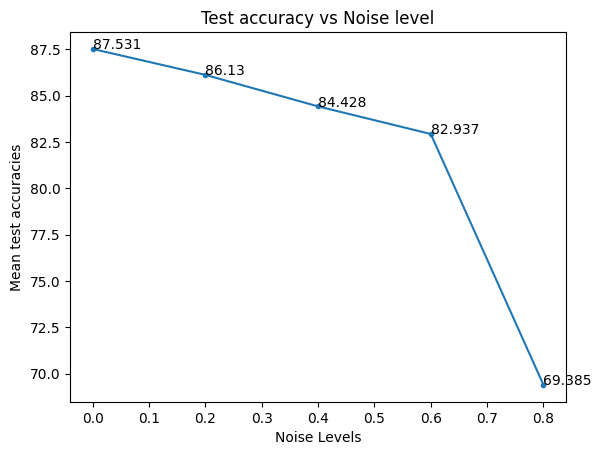

In [56]:
#plot the test accuracies vs epsilon

# For 0% noise levels
# Mean Test accuracy: 87.531
# STD Test accuracy: 1.579

# For 20% noise levels
# Mean Test accuracy: 86.130
# STD Test accuracy: 1.778

# For 40% noise levels
# Mean Test accuracy: 84.428
# STD Test accuracy: 2.668

# For 60% noise levels
# Mean Test accuracy: 82.937
# STD Test accuracy: 2.845

# For 80% noise levels
# Mean Test accuracy: 69.385
# STD Test accuracy: 6.504

mean_test_accuracies = [87.531, 86.130, 84.428, 82.937, 69.385]
noise_levels = [0.0, 0.20, 0.40, 0.60, 0.80]

plt.figure()
plt.plot(noise_levels, mean_test_accuracies, marker='.')

for i, j in zip(noise_levels, mean_test_accuracies):
  plt.annotate(j,(i,j))

plt.xlabel("Noise Levels")
plt.ylabel("Mean test accuracies")
plt.title("Test accuracy vs Noise level")
plt.show()